<a href="https://colab.research.google.com/github/jjiguaran/series_de_tiempo/blob/master/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explanation
## Prophet

![Image for post](https://miro.medium.com/max/2135/1*ATWC39w-KtmvU_mNDWNxLw.png)

Prophet es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante los datos faltantes y los cambios de tendencia, y normalmente maneja bien los valores atípicos.

Según el artículo de Facebook, Prophet usa un modelo aditivo:

y(t)=g(t)+s(t)+h(t)+ϵt

Dónde:

**g (t)** es la función de tendencia que modela cambios no periódicos usando un modelo de crecimiento de saturación no lineal o un modelo de regresión lineal por partes. Puede configurar esto usando parámetros.

**s (t)** es el funcional estacional (anual, semanal y diario) que modela los cambios periódicos en el valor de la serie temporal. Este componente se modela mediante una transformada de Fourier y, si lo desea, puede agregar sus propias estacionalidades.

**h (t)** representa la función para modelar días festivos y eventos de impacto especial. Puede agregar su propio conjunto de feriados personalizados y eventos especiales.

**εt** es el error / ruido de los modelos que se supone que tiene una distribución normal

 Nuestros datos son mensuales, por lo que no podemos modelar con días festivos.

La sintaxis es similar a scikit-learn con llamadas a las funciones de ajuste y predicción. Necesitamos crear un nuevo marco de datos para pronosticar a través de la función make_future_dataframe. El parámetro freq controla la frecuencia (por ejemplo, "D" para días, "M" para meses).

Prophet espera que las columnas tengan nombres específicos, `ds`para la parte temporal y `y`para la parte de valor. Así que nos adherimos a eso.

La _columna yhat_ contiene las predicciones y luego tiene las bandas superior e inferior de las predicciones. Aunque el marco de datos de pronóstico contiene todos los datos que necesita para hacer sus propios gráficos, Prophet también proporciona métodos prácticos para el trazado. En aras de la brevedad, utilizaremos los métodos incorporados donde podamos, pero cuando sea necesario, haremos nuestros propios gráficos personalizados con plotly. Trazar nuestro pronóstico con Prophet se puede hacer así:

Esta trama del Prophet no contiene todos los puntos de cambio, solo los más importantes. Si desea verlos todos, puede usar el siguiente código:

**Observaciones:**

-   Especificamos ajustar el `yearly_seasonality`con la opción _automática_ para los modos de Fourier.
-   Pedimos el 0,95 en `interval_with`lugar del predeterminado (0,8).
-   Incluimos la `mcmc_samples`opción de obtener incertidumbre en la estacionalidad (mediante muestreo bayesiano).

Esto podría indicar un posible sobreajuste. En una segunda iteración, se podría modificar `prior_scale`en la definición del modelo para agregar más regularización. 

### Opciones de incertidumbre / Opciones de tendencia / Opciones de vacaciones

Hay opciones para controlar la incertidumbre, la tendencia (tipo (o modo), el punto de cambio y la visualización) y el efecto de las vacaciones (país o entrada del usuario). He aquí un resumen: 
![Imagen para publicación](https://miro.medium.com/max/1615/1*ZKYf5HQQSA3K2VAlTb1eDQ.png)

Hay muchas opciones en Prophet para controlar la estacionalidad. Estacionalidad anual, semanal y diaria y su granularidad; modo de estacionalidad (aditivo / multiplicativo); estacionalidad definida por el usuario, incluida la estacionalidad condicional.


![Imagen para publicación](https://miro.medium.com/max/1628/1*G_pFdUpeL5UIA6NMBXVV_g.png)


https://medium.com/swlh/facebook-prophet-426421f7e331



## Puntos de cambio de tendencia
La tendencia en una serie en tiempo real puede cambiar abruptamente. Prophet intenta detectar estos cambios automáticamente usando un previo laplaciano o doble exponencial. De forma predeterminada, los puntos de cambio solo se ajustan para el primer 80% de la serie temporal, lo que permite una pista suficiente para el pronóstico real. 

Para ajustar el cambio de tendencia, podemos usar el parámetro changepoint_prior_scale que está configurado en 0.05 por defecto. Aumentar su valor haría que la tendencia fuera más flexible y reduciría el desajuste, con el riesgo de sobreajuste. Fijémoslo en 0.5 como sugiere la Guía de documentación de Prophet. Si queremos generar intervalos de incertidumbre para los componentes de tendencia y estacionalidad, necesitamos realizar un muestreo bayesiano completo, lo que se puede hacer utilizando el parámetro mcmc_samples en Prophet.

## Plot model components

El usuario también puede definir manualmente los puntos de cambio en función del conocimiento del dominio (por ejemplo, al pronosticar las ventas, el analista puede estar al tanto de lanzamientos de nuevos productos, ventas, etc.). Usando la función plot_components podemos mostrar los componentes del modelo:

Observamos una tendencia lineal por partes. Prophet también tiene la capacidad de adaptarse a las tendencias de saturación utilizando un modelo de tendencia de crecimiento logístico. Esto es aplicable en casos donde la tendencia está limitada por la capacidad, p. Ej. el número de usuarios de Facebook en un país estaría naturalmente limitado por el número de personas con acceso a Internet. Esto se hace configurando el parámetro growth = logistic y definiendo una columna llamada cap en el marco de datos.

## Cross validation
Podemos realizar una validación cruzada para medir el error de pronóstico. Se seleccionan los puntos de corte y entrenamos el modelo con los datos hasta ese punto. Luego, podemos comparar la predicción con los datos reales en un horizonte de tiempo específico. Esto se puede hacer usando la función cross_validation. El período del parámetro especifica el intervalo entre los puntos de corte.

La biblioteca Prophet hace posible dividir nuestros datos históricos en datos de entrenamiento y datos de prueba para la validación cruzada. Los principales conceptos para la validación cruzada con Prophet son:

-   **Datos de entrenamiento (inicial)** : la cantidad de datos reservados para el entrenamiento. El parámetro está en la API llamado initial.
-   **Horizonte** : Los datos reservados para validación. Si no define un período, el modelo se ajustará a Horizon / 2.
-   **Cutoff (período)** : se realiza una previsión para cada punto observado entre el corte y el corte + horizonte.

El marco de datos resultante ahora se puede utilizar para calcular medidas de error de _yhat -  y_ . A continuación, he trazado un gráfico con algunos marcadores para ayudarlo a comprender de una manera más visual. 

La salida de cross_validation es un marco de datos con los valores reales y y los valores de pronóstico fuera de la muestra `yhat`, en cada fecha de pronóstico simulada y para cada fecha de corte. En particular, se hace un pronóstico para cada punto observado entre `cutoff`y `cutoff + horizon`. Este marco de datos se puede utilizar para calcular medidas de error de yhat frente a y.

Así que ahora hemos hecho nuestro primer pronóstico con la biblioteca Prophet. Pero, ¿cómo sabemos si los resultados son buenos? Afortunadamente, Prophet viene con algunas métricas de rendimiento integradas que pueden ayudarnos. No voy a entrar en detalles cuando se trata de qué métricas usar y eso lo dejo a usted. Las métricas de rendimiento disponibles son:

-   **Mse** : error absoluto medio
-   **Rmse** : error cuadrático medio
-   **Mae** : error medio medio
-   **Mape** : error porcentual medio medio
-   **Mdape** : error porcentual medio promedio

El código para validar y recopilar métricas de rendimiento se muestra a continuación. Primero necesita obtener los datos de validación cruzada (ya lo hicimos en la lista de códigos anterior, es el marco de datos llamado `cv_df`) Luego, colocamos el marco de datos de validación cruzada en el método Prophet `perfomance_metrics`, así:

## Add regressor

Los regresores adicionales pueden ser discretos como las vacaciones futuras u otra serie temporal. Sin embargo, esta serie temporal debe conocerse o preverse por separado para fechas futuras.

Tenga en cuenta que no siempre es posible predecir estos parámetros por adelantado; este regresor adicional también se puede pronosticar, con un error de pronóstico asociado.

Agregar regresores adicionales es bastante sencillo, pero recuerde que si va a usar algunos en su modelo de pronóstico, debe tener los datos presentes de antemano. Con datos meteorológicos, esto se puede lograr con pronósticos meteorológicos. En mi humilde opinión, los regresores adicionales más fáciles y sólidos que puedes usar son los días festivos y las fechas especiales que conoces, así que te animo a que trabajes un poco más en ellos. Pero volvamos a los datos meteorológicos.

Prophet tiene varias formas de agregar días festivos y eventos especiales. El más fácil y conveniente es utilizar los días festivos nacionales integrados. Las vacaciones para cada país las proporciona el paquete de vacaciones en Python. Una lista de países disponibles y el nombre del país que se utilizará está disponible en su página: [https://github.com/dr-prodigy/python-holidays]

```
# List the holiday names
m.train_holiday_names
```

La última línea de código enumera todos los días festivos incorporados y, por lo que parece, la lista parece ser correcta, aunque podría aumentarse con fechas para Nochebuena o Nochevieja y tal vez otras, pero es un comienzo. Si queremos ver el pronóstico y los efectos que hacen los regresores de vacaciones podemos trazarlo así:

## Hiperparametros
Prophet tiene bastantes parámetros para que los sintonices. No voy a profundizar en los detalles de todos ellos, pero a continuación puede ver el código que puede usar para probar diferentes hiperparámetros en un bucle y luego elegir los mejores. Recuerde que si opta por probar todos los parámetros de una vez, el número de permutaciones será elevado y el tiempo de ejecución considerable. Elegí ajustar un parámetro a la vez y dejé las matrices de parámetros con las que comencé en los comentarios para que las probara usted mismo.

## Conclussion
Prophet es fácil e intuitivo de usar y los componentes del modelo son fácilmente explicables. También permite la incorporación del conocimiento del dominio en el modelo, por ejemplo, a través de puntos de cambio conocidos o límites de capacidad. Los pronósticos son bastante decentes, pero en algunos casos, ciertos parámetros deben modificarse en comparación con la configuración predeterminada, lo que se hace fácilmente.


In [2]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import numpy as np
from fbprophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
plt.style.use(["default"])
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [3]:
url = 'https://raw.githubusercontent.com/jjiguaran/series_de_tiempo/master/df_variaciones.csv'
url = 'https://raw.githubusercontent.com/jjiguaran/series_de_tiempo/master/df_final.csv'
df = pd.read_csv(url, index_col=0).reset_index()
# df.drop(columns=['PIB' ],inplace=True)
df.head()

index     Turistas   DEXBZUS  14 a 17 anos  18 a 24 anos  25 a 39 anos  40 a 59 anos  60 anos ou mais     Total  PIB      Ingreso  IPCA  tipo_cambio_a3500  temp_max  temp_min  CEPO  1 y 2 estrellas  3 estrellas  4 estrellas  5 estrellas       Apart    Boutique     Hostel  Otros/resto
0  2012-01-01  88318.57205  1.785035     24.800000     16.400000      7.200000      4.000000         2.000000  7.900000  3.7  1387.000000  0.56           4.319719      31.8      20.7     1       192.060606   272.380952   372.512821   840.913043  352.800000  525.703704  86.570248   125.100629
1  2012-02-01  59186.46835  1.716800     24.800000     16.400000      7.200000      4.000000         2.000000  7.900000  3.4  1387.000000  0.45           4.347507      30.0      19.7     1       196.050505   273.111111   375.705128   835.521739  345.232877  509.654321  83.254098   125.132911
2  2012-03-01  59478.95959  1.795300     24.800000     16.400000      7.200000      4.000000         2.000000  7.900000  3.1  1387.000000  0.21           4.355723      26.6      16.8     1       202.575758   276.619048   399.543210   897.416667  355.794521  525.444444  88.831933   122.917722
3  2012-04-01  70629.60541  1.852248     23.933333     16.166667      7.166667      3.866667         2.066667  7.766667  2.8  1394.666667  0.64           4.396693      23.3      12.8     1       207.393939   280.174603   388.518519   850.458333  356.100000  510.100000  73.051724   126.974684
4  2012-05-01  67893.16757  1.981023     23.066667     15.933333      7.133333      3.733333         2.133333  7.633333  2.5  1402.333333  0.36           4.449077      20.6      13.2     1       199.800000   280.300000   387.703704   827.916667  355.945946  497.123457  72.827586   132.605096

In [4]:
df['month'] = pd.DatetimeIndex(df['index']).month


df['Ingreso'] = df['Ingreso'] / df['DEXBZUS']
df['Cambio'] = df['tipo_cambio_a3500'] / df['DEXBZUS']

for col in ['1 y 2 estrellas', '3 estrellas', '4 estrellas', '5 estrellas', 'Apart','Boutique', 'Hostel', 'Otros/resto']:
    df[col] = df[col] / df['tipo_cambio_a3500']
    df[col] = df[col] / df['Ingreso']
    

# df = pd.concat([df, pd.get_dummies(df['month'])], axis=1)
df.drop(columns=['month',  'DEXBZUS', 'tipo_cambio_a3500',
                 '14 a 17 anos', '18 a 24 anos', '25 a 39 anos', '40 a 59 anos', '60 anos ou mais', 
                 'temp_min', 'Total', 'Ingreso', 'CEPO', 'IPCA',
                '1 y 2 estrellas','4 estrellas', '5 estrellas', 'Apart','Boutique', 'Hostel', 'Otros/resto','3 estrellas' ],inplace=True)
df.head(2)

index     Turistas  PIB  temp_max    Cambio
0  2012-01-01  88318.57205  3.7      31.8  2.419963
1  2012-02-01  59186.46835  3.4      30.0  2.532332

In [5]:
df.corr()

Turistas       PIB  temp_max    Cambio
Turistas  1.000000  0.409960 -0.480519  0.220997
PIB       0.409960  1.000000  0.063977  0.047494
temp_max -0.480519  0.063977  1.000000  0.048125
Cambio    0.220997  0.047494  0.048125  1.000000

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots()

# # Add traces
# fig.add_trace(
#     go.Scatter(x=df['index'], y=df.PIB, name="PIB")
# )


# Add traces
fig.add_trace(
    go.Scatter(x=df['index'], y=df['PIB'])
)

# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)
fig.show()


In [7]:
df.columns

Index(['index', 'Turistas', 'PIB', 'temp_max', 'Cambio'], dtype='object')

In [8]:
reg_cols = []
for index, col in enumerate(df.columns[2:]):
    print(col)
    df['regr'+str(index)] = df[col]
    reg_cols.append('regr'+str(index))

reg_cols

PIB
temp_max
Cambio


['regr0', 'regr1', 'regr2']

In [9]:
# reg_cols = ['regr0', 'regr1', 'regr2', 'regr3', 'regr4', 'regr5']

# month_cols = ['regr13','regr14','regr15','regr16','regr17','regr18',
#               'regr19','regr20','regr21','regr22','regr23','regr24']

In [10]:
# df['regr1'] = (df['Ingreso'] / df['DEXBZUS']) 
# df['regr2'] = df['temp_min']
# df['regr3'] = df['temp_max']
# df['regr4'] = df['tipo_cambio_a3500']
# df['regr5'] = df['DEXBZUS']

print(df.shape)
df = df.rename(columns={'index': 'ds', 'Turistas': 'y'})
df['ds'] = pd.to_datetime(df['ds'],format='%Y-%m-%d')

# Define threshold date.
threshold_date = pd.to_datetime('2019-02-01')
mask = df['ds'] <= threshold_date

# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]
print(df_train.shape)
print(df_test.shape)

df_test.head()

(98, 8)
(86, 2)
(12, 2)


ds             y
86 2019-03-01   61902.99982
87 2019-04-01   59837.00000
88 2019-05-01   69763.00000
89 2019-06-01   74633.00000
90 2019-07-01  103483.00000

In [11]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x=df_train.ds, y=df_train.y, name="Train")
)

fig.add_trace(
    go.Scatter(x=df_test.ds, y=df_test.y, name="Test", mode='lines')
)

fig.add_trace(go.Scatter(
    x=['2019-02-15','2019-02-15'],
    y=[df_train.y.min(), df_train.y.max()],
    name = 'General Target',
    line=dict(color='grey', width=3, dash='dot'),
    mode = 'lines',
    showlegend=False),
)

# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)
fig.show()


In [12]:
# # Split the data and select `ds` and `y` columns.
# df_train = df[mask][['ds', 'y']]
# df_test = df[~ mask][['ds']]

# Time Series Decomposition
We begin the analysis by decomposing the (training) time series into the trend, seasonal and residual components.

In [13]:
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# from matplotlib import style
# style.use('dark_background')

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train.set_index('ds'), 
    model='additive'
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



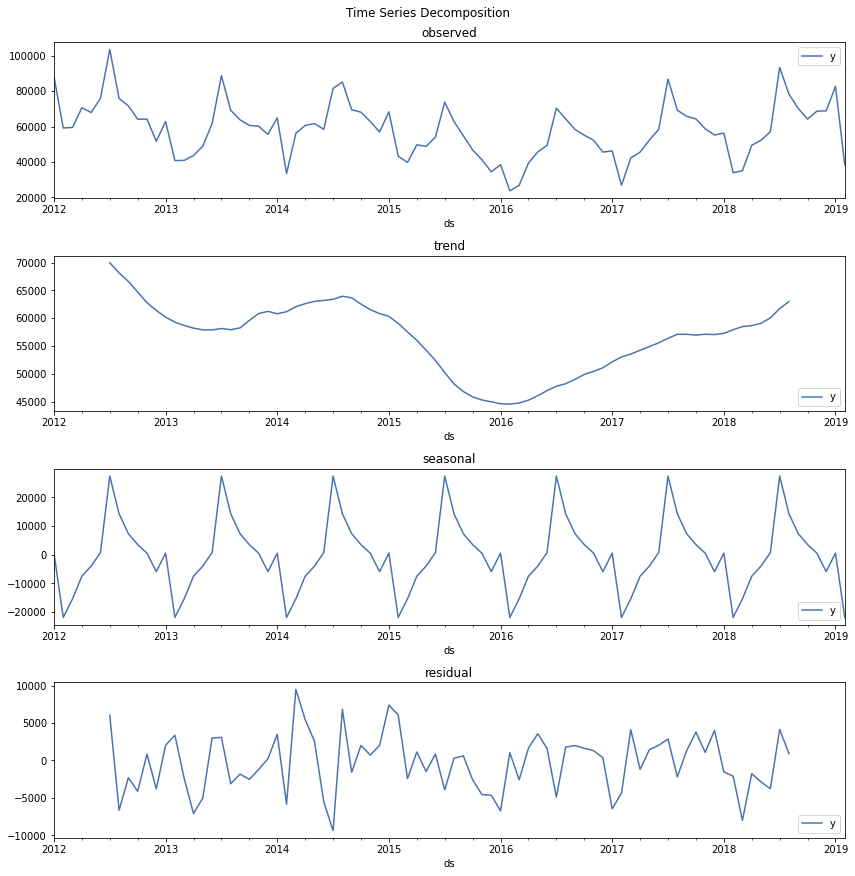

In [15]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Observed time series.
decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
# Trend component. 
decomposition_obj.trend.plot( ax=ax[1])
ax[1].legend(loc='lower right')
ax[1].set(title='trend')
# Seasonal component. 
decomposition_obj.seasonal.plot( ax=ax[2])
ax[2].legend(loc='lower right')
ax[2].set(title='seasonal')
# Residual.
decomposition_obj.resid.plot( ax=ax[3])
ax[3].legend(loc='lower right')
ax[3].set(title='residual')

fig.suptitle('Time Series Decomposition', y=1.01)
plt.tight_layout()

# Basico prophet additive

In [16]:
# Fitting a Prophet model
model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5)

# m.add_seasonality(name='monthly', period=12, fourier_order=5)
model.fit(df_train)

# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')
# Generate predictions. 
forecast = model.predict(df=future)

In [17]:
forecast.tail()

ds         trend    yhat_lower    yhat_upper   trend_lower   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper        yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper          yhat
93 2019-09-30  73282.562971  63006.251978  83984.735319  66545.362011  80025.349190      -26.288811            -26.288811            -26.288811    -26.288811    -26.288811    -26.288811                   0.0                         0.0                         0.0  73256.274160
94 2019-10-31  73951.046494  56420.945002  77754.468583  65666.897668  82016.759685    -6655.229816          -6655.229816          -6655.229816  -6655.229816  -6655.229816  -6655.229816                   0.0                         0.0                         0.0  67295.816677
95 2019-11-30  74597.966032  56927.593611  80561.088388  65160.307425  83902.268733    -6337.599484          -6337.599484          -6337.599484  -6337.599484  -6337.599484  -6337.599484                   0.0                         0.0                         0.0  68260.366548
96 2019-12-31  75266.449554  71524.468082  96702.157371  64705.685467  85930.801678     8303.178118           8303.178118           8303.178118   8303.178118   8303.178118   8303.178118                   0.0                         0.0                         0.0  83569.627673
97 2020-01-31  75934.933077  39291.055510  68373.235617  63961.942755  88197.434815   -21985.507356         -21985.507356         -21985.507356 -21985.507356 -21985.507356 -21985.507356                   0.0                         0.0                         0.0  53949.425722

In [18]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

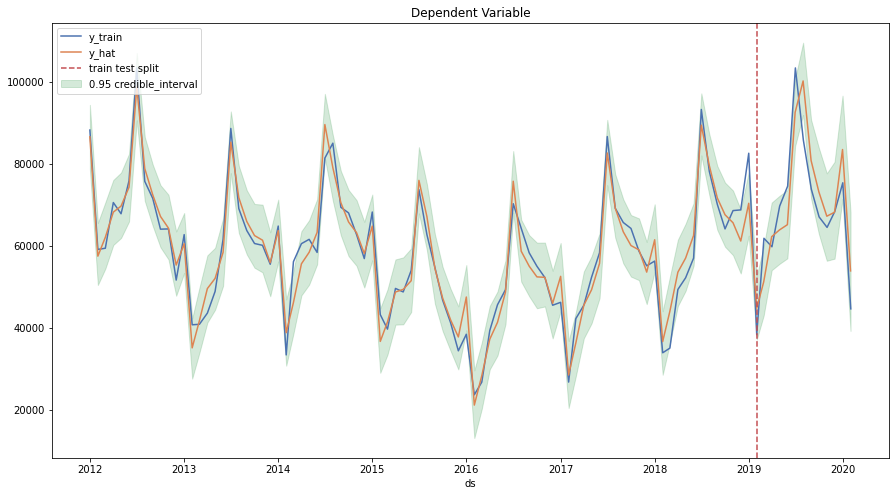

In [19]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

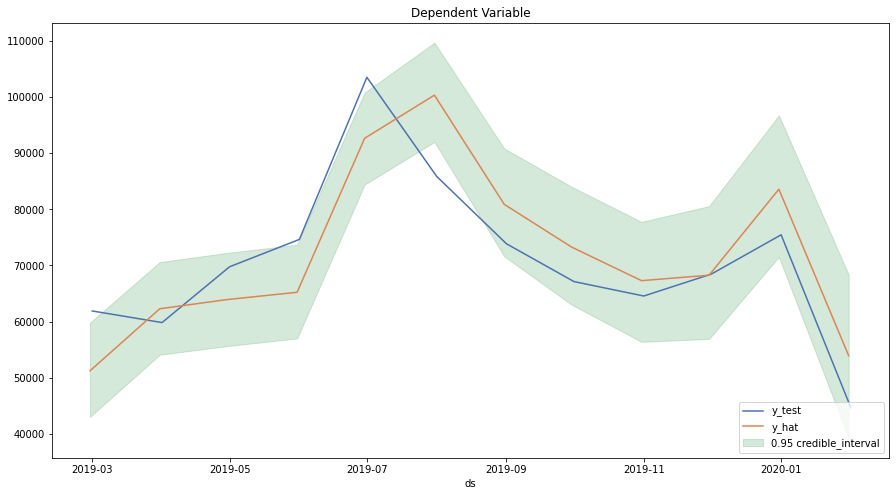

In [20]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

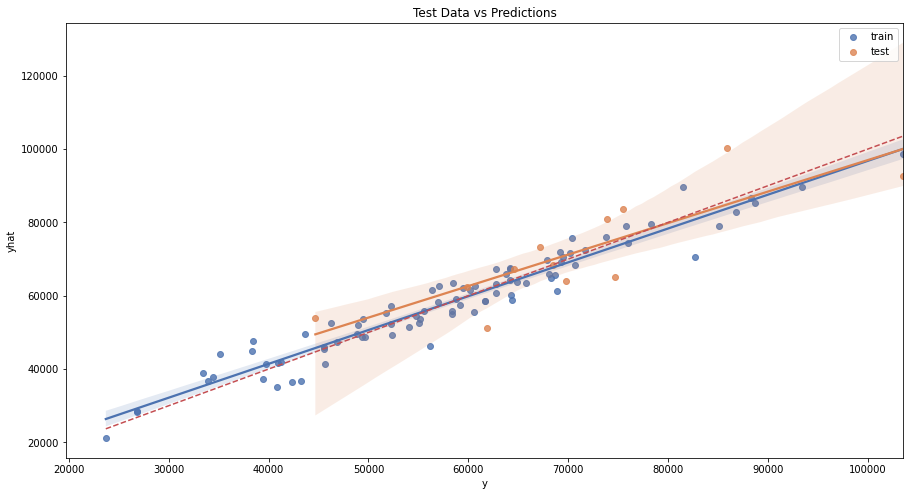

In [21]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [22]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9325767295332394
r2 test: 0.6427924822037459
------------------------------
mae train: 3217.785350332825
mae test: 7259.82463449191
mape train: 5.997437143624829
mape test: 10.354471351942909
RMSE train: 4045.305626386222
RMSE test: 8239.457074148193


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



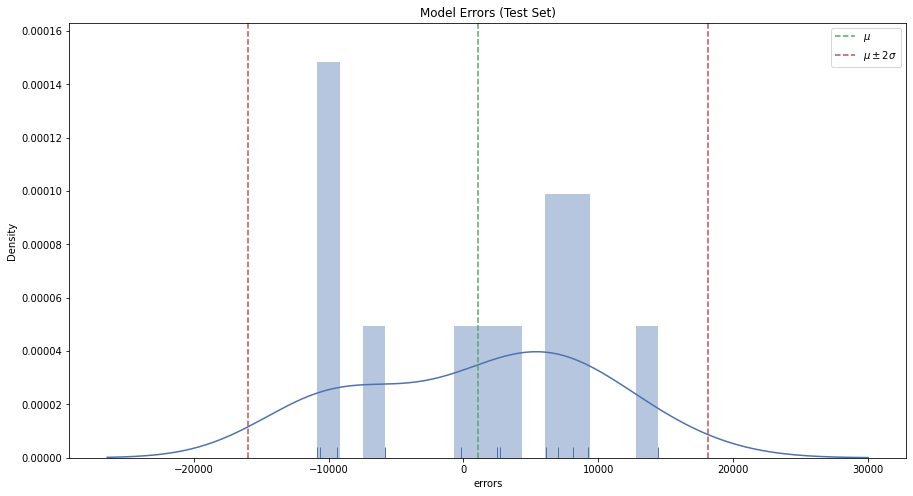

In [24]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

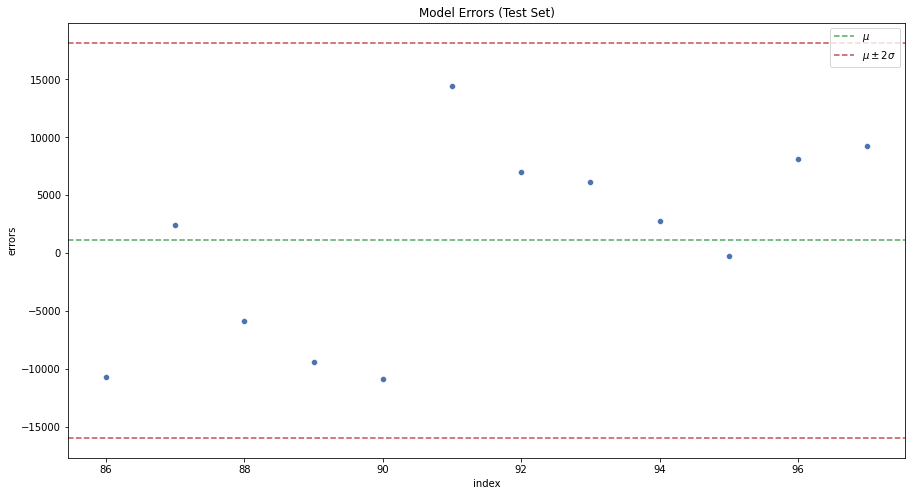

In [25]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



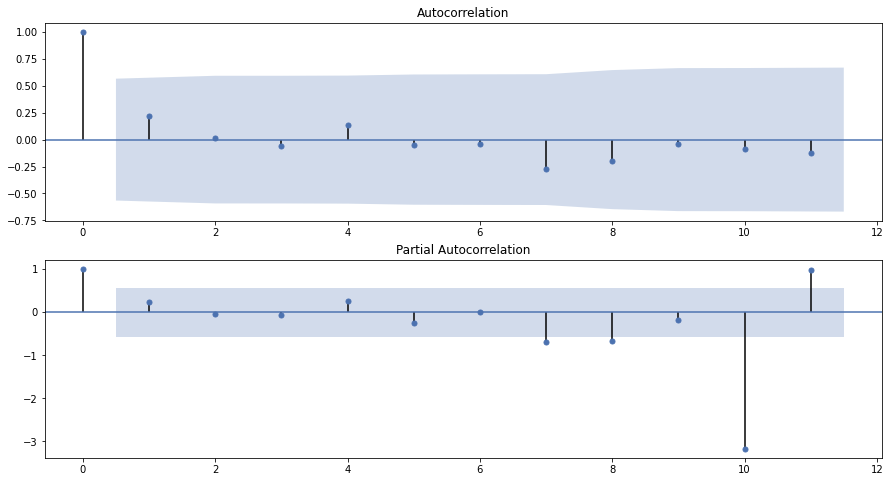

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

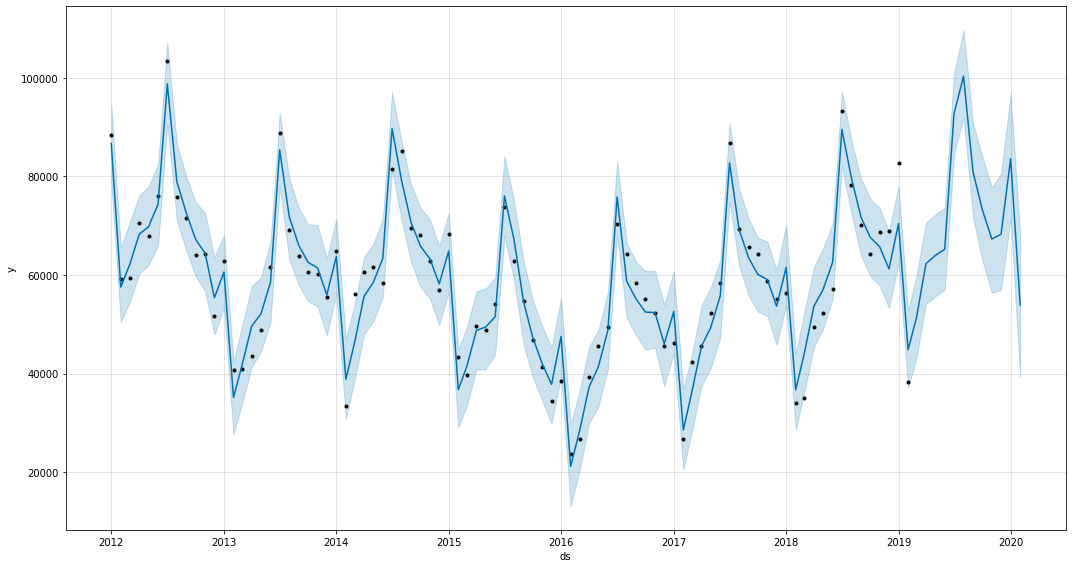

In [27]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True, figsize=(15,8))

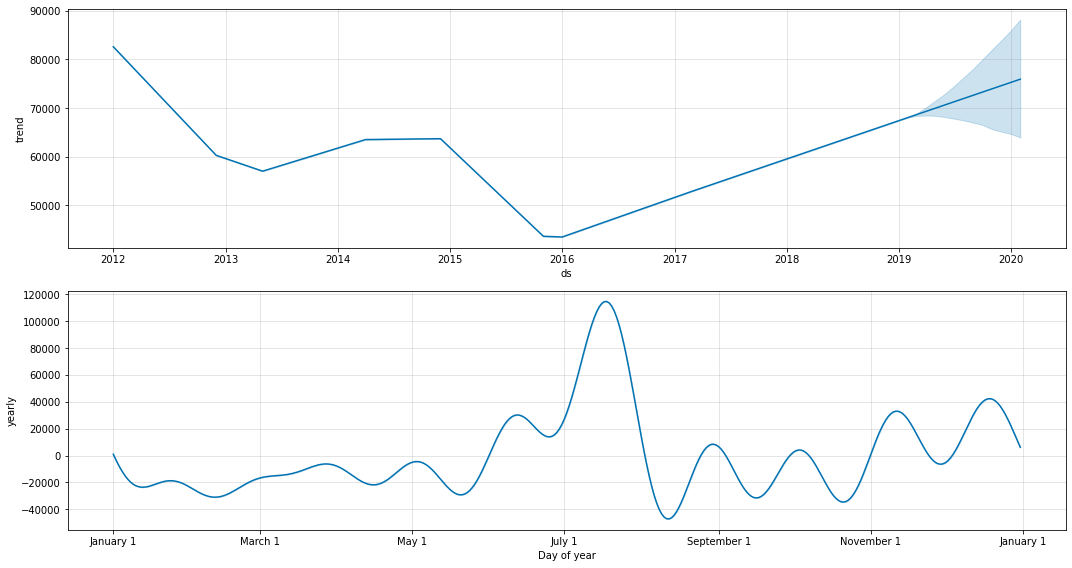

In [28]:
# Plotting the forecast components.
fig2 = model.plot_components(forecast, figsize=(15,8))

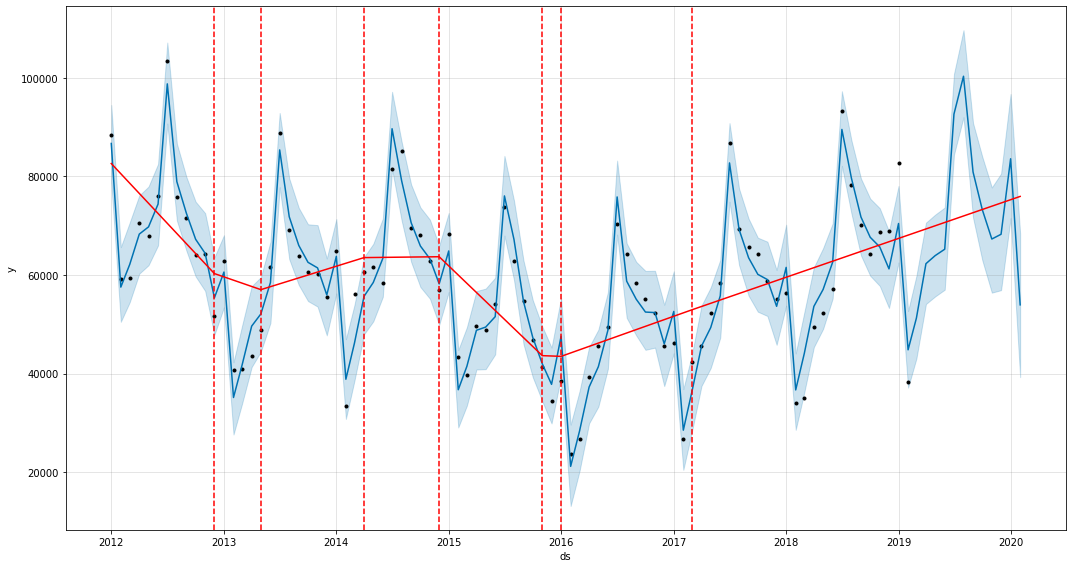

In [29]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [30]:
# Listing all the change points in the model
deltas = model.params['delta'].mean(0)
cp = pd.DataFrame(model.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


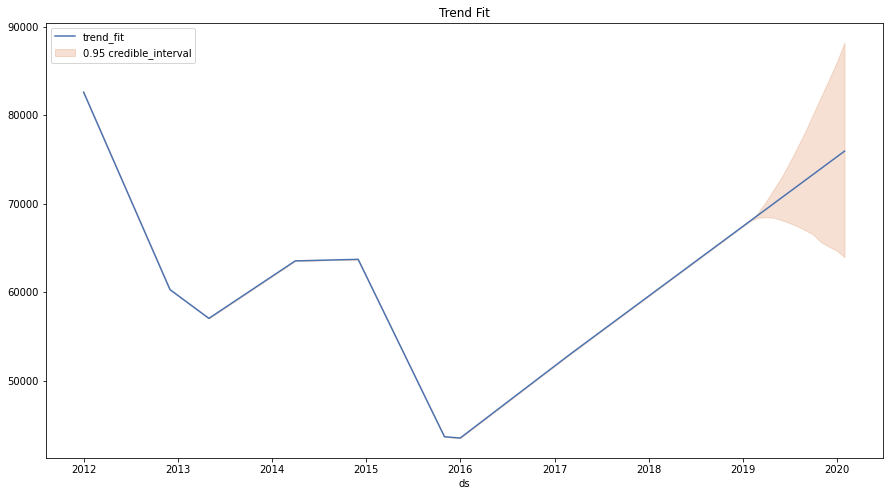

In [31]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [32]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


ds          yhat    yhat_lower    yhat_upper            y              cutoff
0 2017-02-01  31812.174205  25176.769924  37930.789289  26817.99999 2017-01-01 19:12:00
1 2017-03-01  37030.589557  30731.106153  43551.629728  42302.00002 2017-01-01 19:12:00
2 2017-04-01  47116.628217  40502.479623  54208.687640  45565.00001 2017-01-01 19:12:00
3 2017-05-01  50291.755418  43185.710969  57219.834168  52396.00001 2017-01-01 19:12:00
4 2017-06-01  57113.175495  49460.042154  64584.841384  58382.99999 2017-01-01 19:12:00

ds          yhat    yhat_lower    yhat_upper            y     cutoff
163 2018-10-01  69875.407168  59796.524115  80012.641650  64194.00001 2018-02-01
164 2018-11-01  66293.407119  55874.891255  77796.861701  68665.99998 2018-02-01
165 2018-12-01  60226.576711  48337.802663  72316.394759  68836.99998 2018-02-01
166 2019-01-01  68753.925299  55710.706922  81616.052493  82661.99985 2018-02-01
167 2019-02-01  46427.666734  30629.382783  61907.430675  38387.00008 2018-02-01

In [33]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

horizon           mse         rmse          mae      mape     mdape  coverage
0 58 days 09:36:00  2.868367e+07  5355.713332  4089.096734  0.098878  0.042345   0.87500
1 58 days 14:24:00  2.545126e+07  5044.924109  3923.090802  0.090383  0.042345   0.90625
2 58 days 19:12:00  2.116909e+07  4600.988213  3512.199529  0.079185  0.042345   0.93750
3 59 days 00:00:00  2.196869e+07  4687.076867  3560.644279  0.081926  0.039796   0.93750
4 59 days 04:48:00  2.212131e+07  4703.329763  3619.770684  0.082643  0.039796   0.93750

In [34]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         4.22183e+07
rmse                            6441.34
mae                             5301.79
mape                           0.107084
mdape                         0.0746667
coverage                       0.825307
dtype: object

In [35]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

horizon           mae
0    27 days 19:12:00   6361.120897
1    28 days 00:00:00   6758.549516
2    28 days 04:48:00   4052.035690
3    28 days 09:36:00   1998.654552
4    28 days 14:24:00    817.624439
5    28 days 19:12:00   2684.082633
6    29 days 00:00:00   2178.653439
7    29 days 04:48:00   1089.473700
8    29 days 09:36:00    533.516735
9    29 days 14:24:00   2398.723968
10   29 days 19:12:00   6479.266582
11   30 days 04:48:00   4994.174215
12   30 days 09:36:00   5448.306796
13   58 days 04:48:00   5271.410463
14   58 days 09:36:00   6981.262754
15   58 days 14:24:00   4102.454604
16   58 days 19:12:00    184.289148
17   59 days 00:00:00   3412.903116
18   59 days 04:48:00   1763.646930
19   59 days 09:36:00   2370.613749
20   59 days 14:24:00    665.984289
21   59 days 19:12:00     93.127536
22   60 days 00:00:00   1878.159482
23   60 days 04:48:00   6953.400043
24   60 days 19:12:00   6422.152474
25   88 days 19:12:00   8507.938167
26   89 days 00:00:00   5461.535431
27   89 days 04:48:00   1551.628207
28   89 days 09:36:00   3622.596665
29   89 days 14:24:00   1712.086145
30   89 days 19:12:00   1799.741450
31   90 days 00:00:00   1152.542963
32   90 days 04:48:00    883.806394
33   90 days 09:36:00   1940.989892
34   90 days 14:24:00   7330.335703
35   91 days 04:48:00   7014.056486
36  119 days 04:48:00   8072.575662
37  119 days 09:36:00   5744.892886
38  119 days 19:12:00   5196.049538
39  120 days 00:00:00   4433.236827
40  120 days 04:48:00   2765.454421
41  120 days 09:36:00    746.331708
42  120 days 14:24:00    975.775264
43  120 days 19:12:00   2566.655701
44  121 days 00:00:00   6905.585436
45  121 days 14:24:00   7388.550407
46  149 days 14:24:00  14389.596444
47  149 days 19:12:00   7363.515341
48  150 days 00:00:00   4211.324357
49  150 days 04:48:00   4790.431651
50  150 days 09:36:00   5186.283395
51  150 days 14:24:00   2895.720800
52  150 days 19:12:00    438.605860
53  151 days 00:00:00   1258.027359
54  151 days 04:48:00   1522.314728
55  151 days 09:36:00   6796.865934
56  152 days 00:00:00   6963.470637
57  180 days 00:00:00  14011.361092
58  180 days 04:48:00   6747.250102
59  180 days 09:36:00   3014.747887
60  180 days 14:24:00   8698.621733
61  180 days 19:12:00   5060.010408
62  181 days 00:00:00   2917.407921
63  181 days 04:48:00   1478.571977
64  181 days 09:36:00    896.746060
65  181 days 14:24:00   1446.070684
66  181 days 19:12:00   7637.244499
67  182 days 09:36:00   6766.184207
68  210 days 09:36:00  13779.470171
69  210 days 14:24:00   9410.118008
70  210 days 19:12:00   1844.340620
71  211 days 00:00:00   8272.811833
72  211 days 04:48:00   5730.799745
73  211 days 09:36:00   3378.928490
74  211 days 14:24:00   1493.955079
75  211 days 19:12:00   3083.952413
76  212 days 00:00:00   2103.603508
77  212 days 04:48:00   6276.276998
78  212 days 19:12:00   7697.641786
79  240 days 19:12:00  14738.640543
80  241 days 00:00:00   8947.191939
81  241 days 04:48:00   1514.730246
82  241 days 09:36:00   7888.273257
83  241 days 14:24:00  10529.180096
84  241 days 19:12:00   5117.294963
85  242 days 00:00:00   3933.021369
86  242 days 04:48:00   1265.898052
87  242 days 09:36:00   2960.155197
88  242 days 14:24:00   6266.701802
89  243 days 04:48:00   6251.060549
90  271 days 04:48:00  13258.652568
91  271 days 09:36:00   8445.395877
92  271 days 14:24:00   1097.905830
93  271 days 19:12:00   8894.149223
94  272 days 00:00:00  10044.572171
95  272 days 04:48:00   4369.239564
96  272 days 09:36:00   4224.397488
97  272 days 19:12:00   3267.521750
98  273 days 00:00:00   3778.423126
99  273 days 14:24:00   6251.674294
100 301 days 14:24:00  13237.894117
101 301 days 19:12:00   9629.626465
102 302 days 00:00:00   1584.732060
103 302 days 04:48:00   7181.566902
104 302 days 09:36:00   9561.471367
105 302 days 14:24:00   5810.535808
106 302 days 19:12:00   6335.930934
107 303 days 00:00:00   8610.423269
108 303 days 04:48:00   3272.724309
109 303 days 09:36:00   3648.586707
110 304 days 00:00

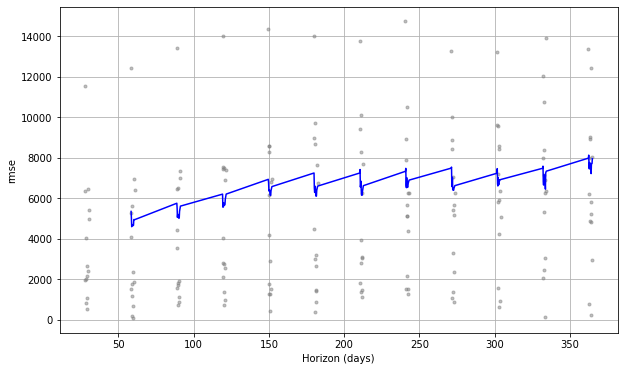

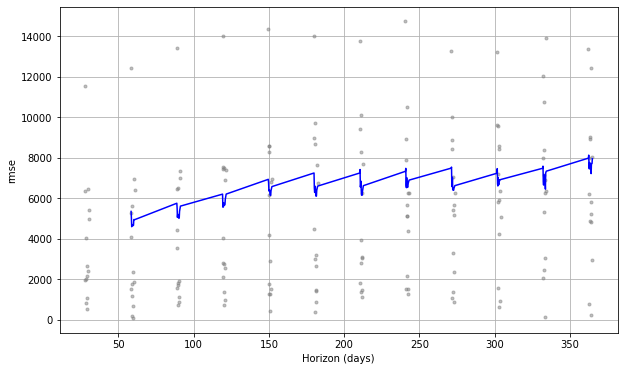

In [36]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [37]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [38]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

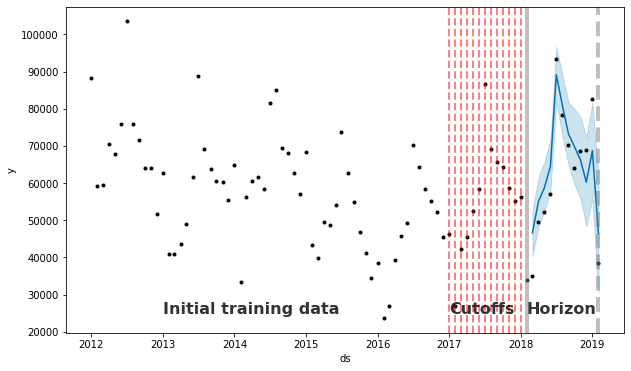

In [39]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model.history['ds'].values, model.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Multiples regresores prophet

In [40]:
reg_cols

['regr0', 'regr1', 'regr2']

In [41]:
def fit_regressor(df_train, df_test, reg_cols):
    # Split the data and select `ds` and `y` columns.
    df_train = df[mask][['ds', 'y'] + reg_cols]
    df_test = df[~ mask][['ds', 'y'] + reg_cols]
    print(df_train.shape)
    print(df_test.shape)
    df_test.tail()


    # Fitting a Prophet model
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False, 
            interval_width=0.95)

    for col in reg_cols:
        model.add_regressor(col)

    model.fit(df_train)

    # Extend dates and features. 
    future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')

    future = future.merge(df[reg_cols ], left_index=True, right_index=True)

    # Generate predictions. 
    forecast = model.predict(df=future)

    mask2 = forecast['ds'] <= threshold_date

    forecast_train = forecast[mask2]
    forecast_test = forecast[~ mask2]
    print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
    print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

    
    return sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))

In [42]:
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y'] + reg_cols]
df_test = df[~ mask][['ds', 'y'] + reg_cols]
print(df_train.shape)
print(df_test.shape)
df_test.tail()

(86, 5)
(12, 5)


ds        y     regr0  regr1      regr2
93 2019-10-01  67129.0  1.033333   22.0  14.332859
94 2019-11-01  64563.0  1.066667   27.8  14.372036
95 2019-12-01  68464.0  1.100000   29.5  14.588550
96 2020-01-01  75454.0  1.033333   30.0  14.451168
97 2020-02-01  44684.0  0.966667   29.6  14.111419

In [43]:
import itertools

# lst = ['regr0', 'regr1', 'regr2', 'regr3', 'regr4', 'regr5', 'regr6']
lst = reg_cols.copy()
combs = []
min_acc = 1000000
best_cols = []
for i in range(1, len(lst)+1):
#     combs.append(i)
    els = [list(x) for x in itertools.combinations(lst, i)]
    for i in els:
        print(i)

        error = fit_regressor(df_train,df_test,i)
        if error < min_acc:
            min_acc = error
            best_cols = i
            print('*** New Min error: ', error)
            print('*** Best features: ', i)
            print('*** Best features: ', best_cols)
            print('*** \n')
# combs

['regr0']
(86, 3)
(12, 3)
RMSE train: 5940.897294216174
RMSE test: 12891.460294099192
*** New Min error:  5940.897294216174
*** Best features:  ['regr0']
*** Best features:  ['regr0']
*** 

['regr1']
(86, 3)
(12, 3)
RMSE train: 6249.524806971079
RMSE test: 9880.63583465035
['regr2']
(86, 3)
(12, 3)
RMSE train: 6271.547448197181
RMSE test: 20141.0329312309
['regr0', 'regr1']
(86, 4)
(12, 4)
RMSE train: 5962.844226530586
RMSE test: 13446.22277959527
['regr0', 'regr2']
(86, 4)
(12, 4)
RMSE train: 5505.308775062184
RMSE test: 13540.916495162022
*** New Min error:  5505.308775062184
*** Best features:  ['regr0', 'regr2']
*** Best features:  ['regr0', 'regr2']
*** 

['regr1', 'regr2']
(86, 4)
(12, 4)
RMSE train: 6207.17188653565
RMSE test: 20299.757834714153
['regr0', 'regr1', 'regr2']
(86, 5)
(12, 5)
RMSE train: 5692.811254003497
RMSE test: 14314.807338700231


In [44]:
best_cols

['regr0', 'regr2']

In [45]:
# Fitting a Prophet model
model_2 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5,
)

for col in best_cols:
    model_2.add_regressor(col)
    
model_2.fit(df_train)

In [46]:
# Extend dates and features. 
future = model_2.make_future_dataframe(periods=df_test.shape[0], freq='M')

future = future.merge(df[reg_cols ], left_index=True, right_index=True)

# Generate predictions. 
forecast = model_2.predict(df=future)

In [47]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

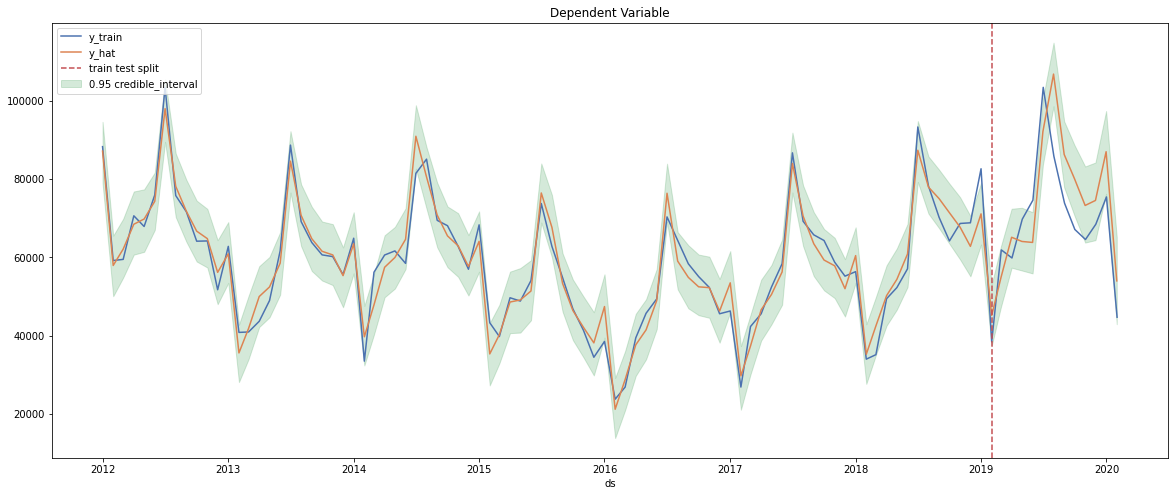

In [48]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

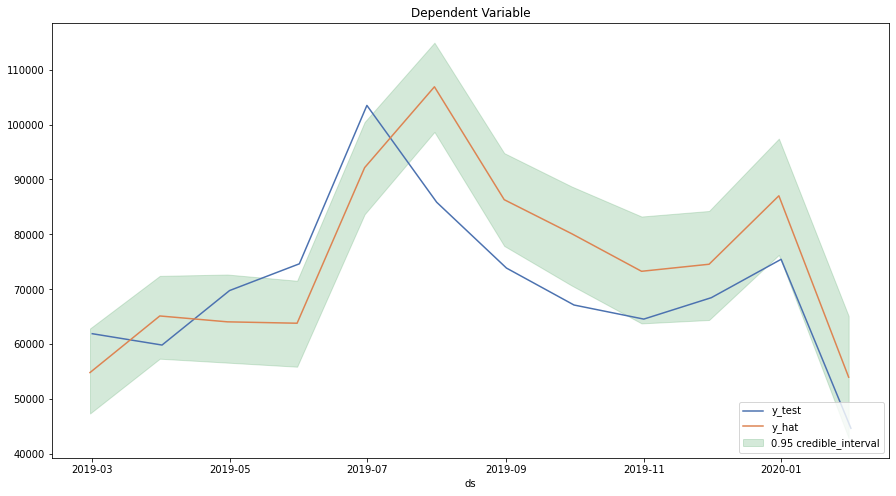

In [49]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

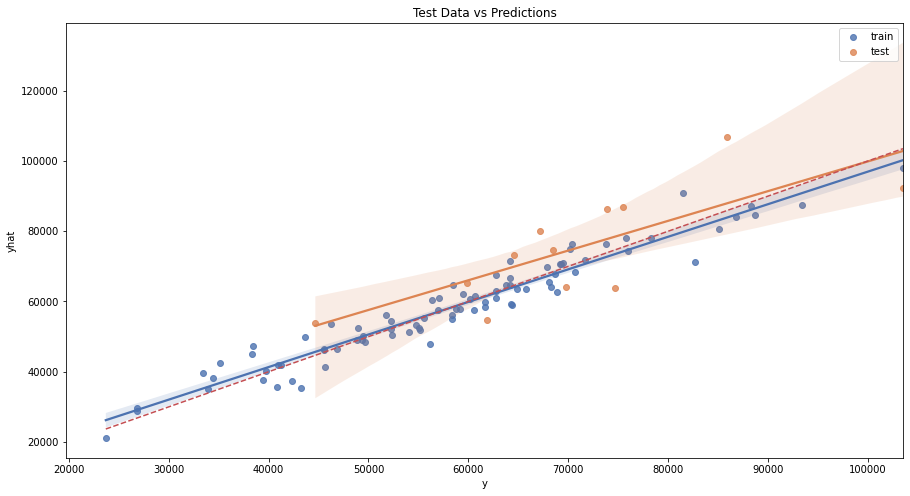

In [50]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [51]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9341017617156114
r2 test: 0.3619023385622808
------------------------------
mae train: 3121.9411409087757
mae test: 10196.691548340148
mape train: 5.815833114073035
mape test: 14.42765615872466
RMSE train: 3999.2940158037045
RMSE test: 11012.397438852597


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



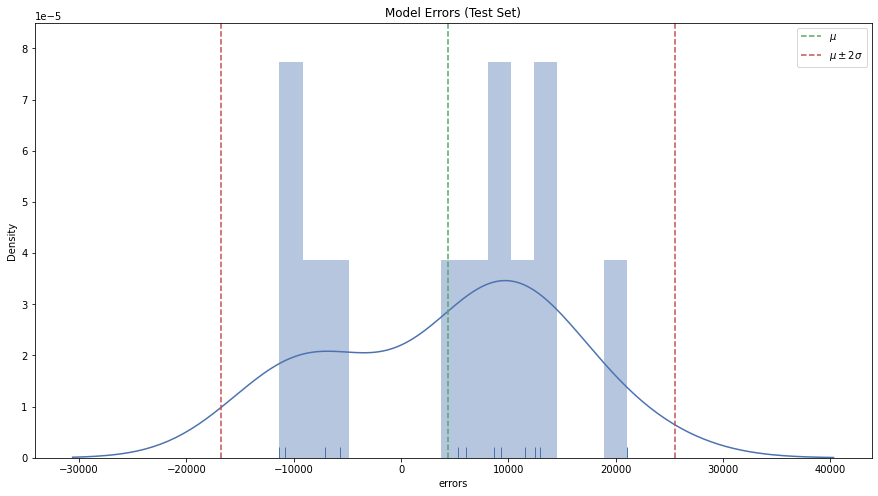

In [52]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

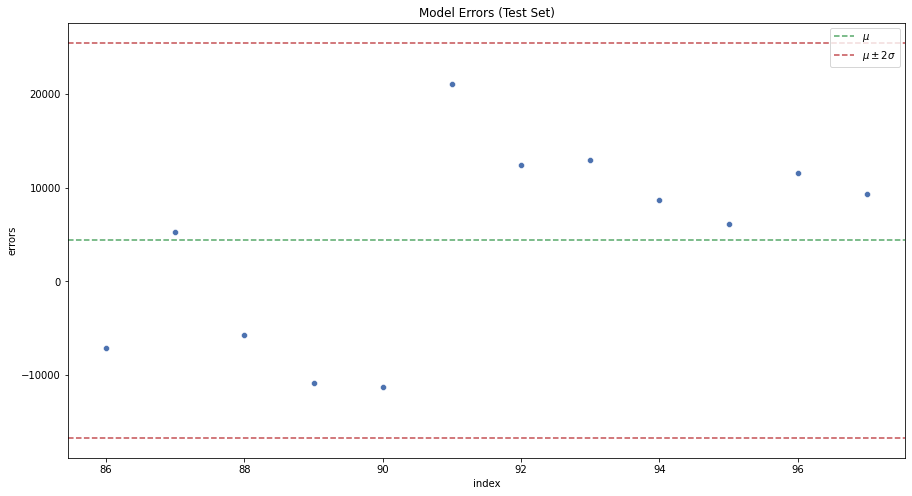

In [53]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



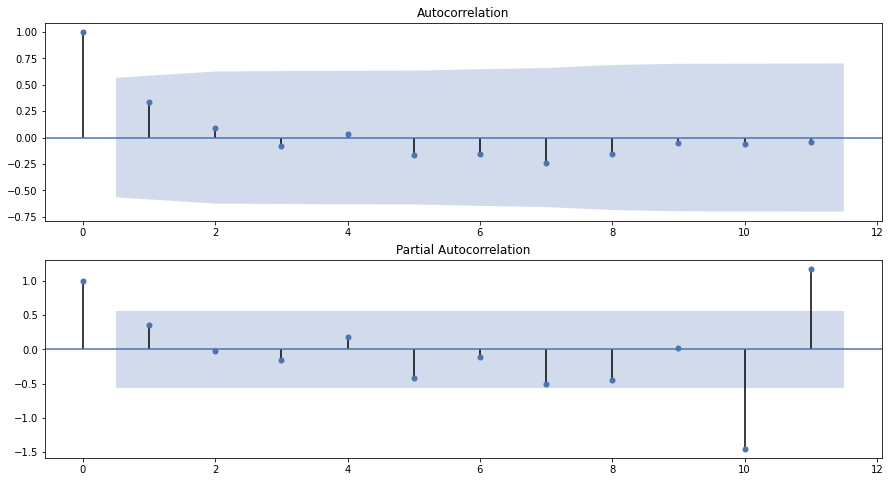

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

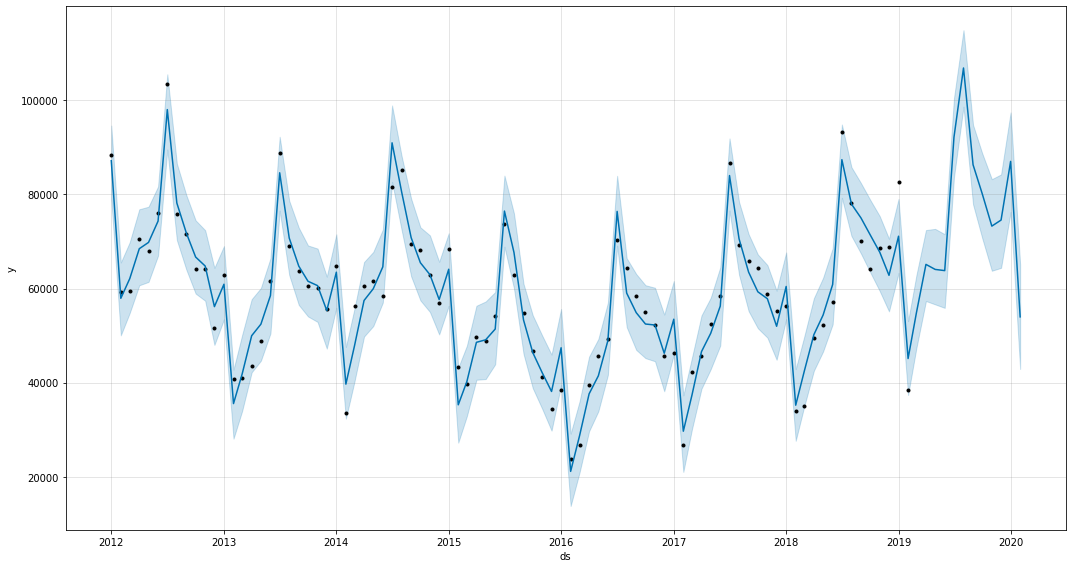

In [55]:
# Plotting the generated forecast
fig1 = model_2.plot(forecast, uncertainty=True, figsize=(15,8))

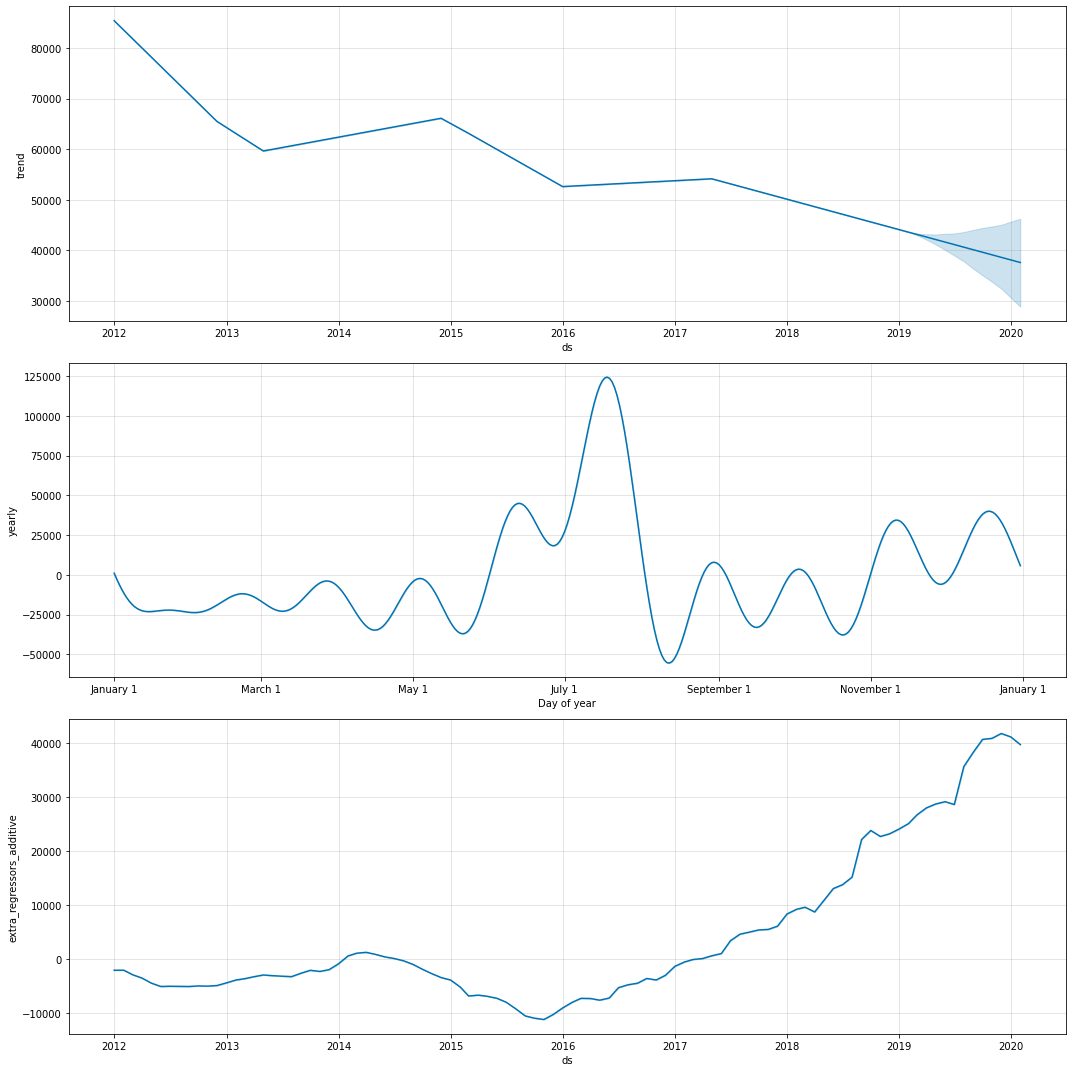

In [56]:
# Plotting the forecast components.
fig2 = model_2.plot_components(forecast, figsize=(15,15))

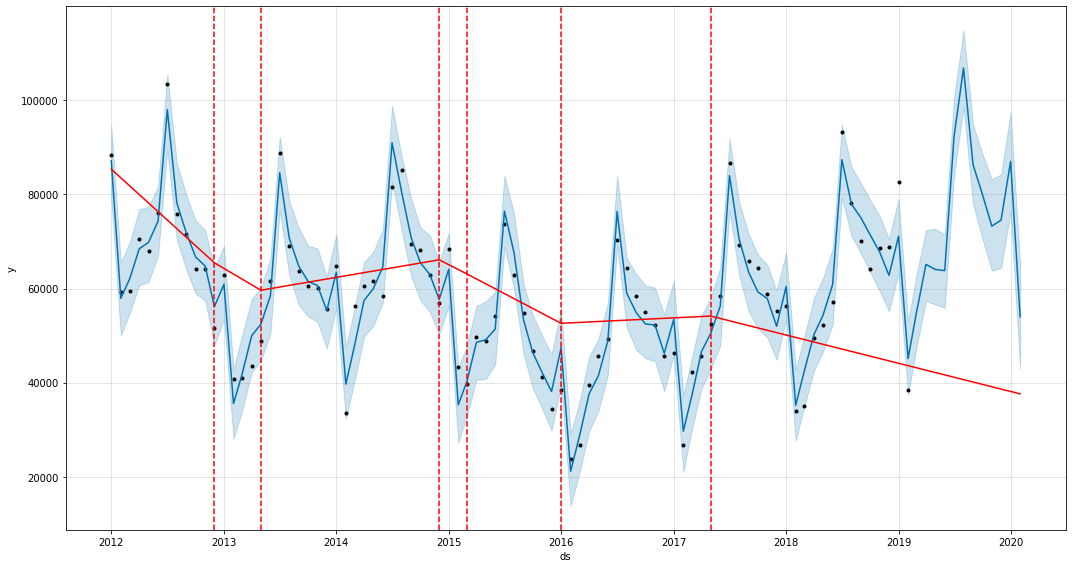

In [57]:
from fbprophet.plot import add_changepoints_to_plot

fig = model_2.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model_2, forecast)

In [58]:
# Listing all the change points in the model
deltas = model_2.params['delta'].mean(0)
cp = pd.DataFrame(model_2.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


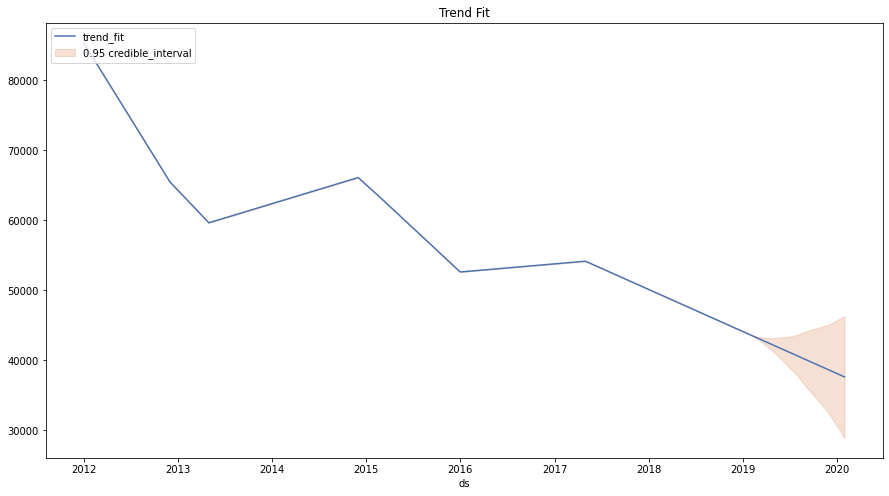

In [59]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [60]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model_2, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


ds          yhat    yhat_lower    yhat_upper            y              cutoff
0 2017-02-01  31754.227923  24886.748130  38345.217773  26817.99999 2017-01-01 19:12:00
1 2017-03-01  35838.659371  29505.075852  42260.951714  42302.00002 2017-01-01 19:12:00
2 2017-04-01  44911.482933  38455.864814  51921.141924  45565.00001 2017-01-01 19:12:00
3 2017-05-01  48466.305317  41630.782896  54959.859023  52396.00001 2017-01-01 19:12:00
4 2017-06-01  55186.615651  47481.494530  61995.723155  58382.99999 2017-01-01 19:12:00

ds          yhat    yhat_lower    yhat_upper            y     cutoff
163 2018-10-01  68203.570671  59455.073609  76717.980445  64194.00001 2018-02-01
164 2018-11-01  61900.758340  52498.278294  71096.307000  68665.99998 2018-02-01
165 2018-12-01  54953.613130  44809.248334  65075.731977  68836.99998 2018-02-01
166 2019-01-01  61718.541783  50586.783987  73257.905075  82661.99985 2018-02-01
167 2019-02-01  38385.719685  25091.319023  51500.562462  38387.00008 2018-02-01

In [61]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

horizon           mse         rmse          mae      mape     mdape  coverage
0 58 days 09:36:00  2.862675e+07  5350.397211  4067.131537  0.097508  0.044767   0.75000
1 58 days 14:24:00  2.535181e+07  5035.058485  3741.788342  0.087930  0.037736   0.78125
2 58 days 19:12:00  2.245717e+07  4738.899740  3526.619508  0.081319  0.044586   0.81250
3 59 days 00:00:00  2.271153e+07  4765.661268  3628.522606  0.083446  0.045858   0.81250
4 59 days 04:48:00  2.547148e+07  5046.927488  4006.850692  0.088806  0.054419   0.81250

In [62]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         8.43224e+07
rmse                            8722.05
mae                             7251.67
mape                           0.142186
mdape                          0.117672
coverage                       0.569672
dtype: object

In [63]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

horizon           mae
0    27 days 19:12:00   8176.488185
1    28 days 00:00:00   6049.965856
2    28 days 04:48:00    662.073034
3    28 days 09:36:00    779.500169
4    28 days 14:24:00    620.936571
5    28 days 19:12:00   6607.726035
6    29 days 00:00:00   1391.441980
7    29 days 04:48:00    831.172107
8    29 days 09:36:00   1415.810109
9    29 days 14:24:00   3032.759163
10   29 days 19:12:00   7161.646441
11   30 days 04:48:00   4936.227933
12   30 days 09:36:00   4994.564522
13   58 days 04:48:00   6463.340649
14   58 days 09:36:00   7038.487084
15   58 days 14:24:00    844.474735
16   58 days 19:12:00   2607.264506
17   59 days 00:00:00   1536.011386
18   59 days 04:48:00   6674.185957
19   59 days 09:36:00    988.451994
20   59 days 14:24:00    252.094431
21   59 days 19:12:00   3760.400104
22   60 days 00:00:00   2652.826390
23   60 days 04:48:00   8275.986568
24   60 days 19:12:00   6581.268236
25   88 days 19:12:00  10041.668761
26   89 days 00:00:00   2110.030340
27   89 days 04:48:00    653.517077
28   89 days 09:36:00   2262.975601
29   89 days 14:24:00   6481.284426
30   89 days 19:12:00   1233.876104
31   90 days 00:00:00    534.007330
32   90 days 04:48:00   3833.692432
33   90 days 09:36:00   3005.101084
34   90 days 14:24:00   8840.309894
35   91 days 04:48:00   7871.153518
36  119 days 04:48:00   9710.024167
37  119 days 09:36:00   3423.509651
38  119 days 19:12:00   5368.335462
39  120 days 00:00:00   4937.789658
40  120 days 04:48:00   1324.102487
41  120 days 09:36:00    226.440921
42  120 days 14:24:00   3623.349277
43  120 days 19:12:00   5171.552478
44  121 days 00:00:00   8422.555818
45  121 days 14:24:00   8438.645106
46  149 days 14:24:00  16077.797830
47  149 days 19:12:00   6948.297265
48  150 days 00:00:00   8654.660948
49  150 days 04:48:00   5005.060954
50  150 days 09:36:00   7015.104264
51  150 days 14:24:00   1095.692381
52  150 days 19:12:00   1817.174534
53  151 days 00:00:00   2852.350124
54  151 days 04:48:00   5272.114501
55  151 days 09:36:00   8568.117781
56  152 days 00:00:00   8097.287623
57  180 days 00:00:00  15591.107275
58  180 days 04:48:00   6642.611813
59  180 days 09:36:00   4428.577081
60  180 days 14:24:00   7407.001502
61  180 days 19:12:00   5376.380168
62  181 days 00:00:00   1142.085844
63  181 days 04:48:00   1931.031268
64  181 days 09:36:00   3153.530098
65  181 days 14:24:00   5026.618869
66  181 days 19:12:00  11139.082348
67  182 days 09:36:00   8403.917633
68  210 days 09:36:00  16013.522450
69  210 days 14:24:00  10410.713537
70  210 days 19:12:00   2192.485679
71  211 days 00:00:00   7459.510160
72  211 days 04:48:00   8533.711344
73  211 days 09:36:00   1697.739881
74  211 days 14:24:00   1667.985453
75  211 days 19:12:00   2879.857251
76  212 days 00:00:00   3097.979500
77  212 days 04:48:00  11214.550134
78  212 days 19:12:00  10646.943193
79  240 days 19:12:00  18541.125202
80  241 days 00:00:00  10041.422922
81  241 days 04:48:00   1568.655296
82  241 days 09:36:00   7601.359692
83  241 days 14:24:00  14124.113291
84  241 days 19:12:00   5581.282707
85  242 days 00:00:00   2304.062288
86  242 days 04:48:00    366.171697
87  242 days 09:36:00   7493.294303
88  242 days 14:24:00  10958.208003
89  243 days 04:48:00  10683.794130
90  271 days 04:48:00  18504.053824
91  271 days 09:36:00  10209.676209
92  271 days 14:24:00   2169.359397
93  271 days 19:12:00   9044.257806
94  272 days 00:00:00  13264.044322
95  272 days 04:48:00   6187.730860
96  272 days 09:36:00   7341.666003
97  272 days 19:12:00   8293.284108
98  273 days 00:00:00   8281.112797
99  273 days 14:24:00  10426.406666
100 301 days 14:24:00  18248.280351
101 301 days 19:12:00  12790.934371
102 302 days 00:00:00   1417.689707
103 302 days 04:48:00   9065.575294
104 302 days 09:36:00  13505.296720
105 302 days 14:24:00  10498.946883
106 302 days 19:12:00  11932.529730
107 303 days 00:00:00  13883.386850
108 303 days 04:48:00  11037.805931
109 303 days 09:36:00   6583.651351
110 304 days 00:00

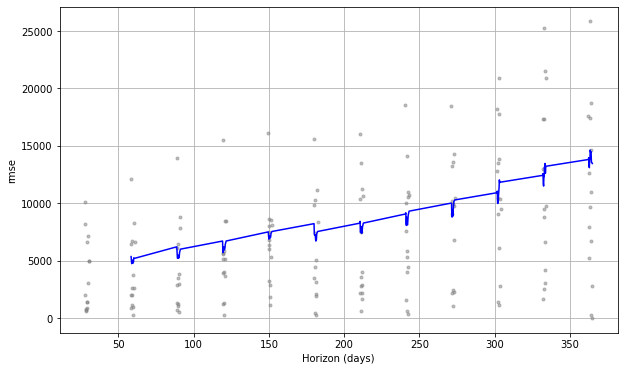

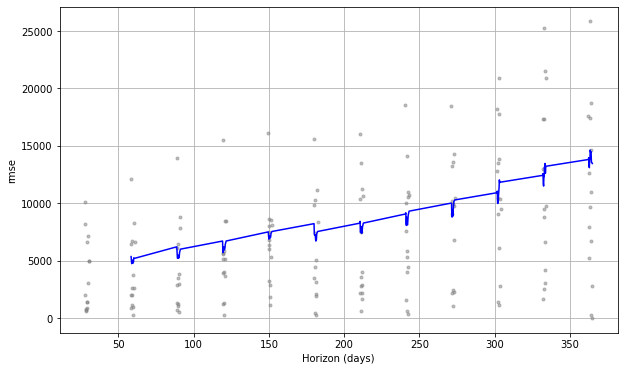

In [64]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [65]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [66]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

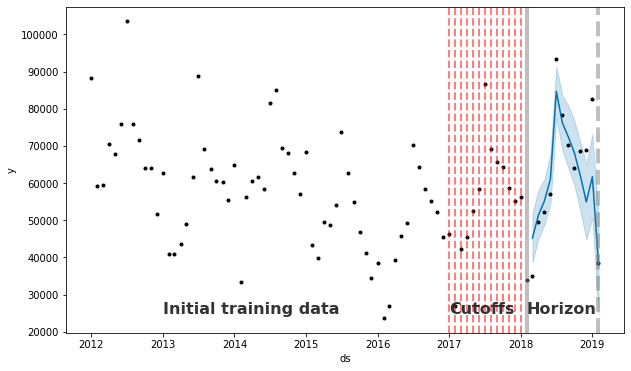

In [67]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model_2.history['ds'].values, model_2.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Multiples regresores prophet

2012	mie	22 de feb	Ash Wednesday	Christian
2013	mie	13 de feb	Ash Wednesday	Christian
2014	mie	5 de mar	Ash Wednesday	Christian

In [68]:
from datetime import timedelta
import datetime

holidays = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])

dates_carn = ['2012-02-22','2013-02-13','2014-03-05','2015-02-18','2016-02-10',
                  '2017-03-01','2018-02-14','2019-03-06','2020-02-26']

for date in dates_carn:
  date_1 = datetime.datetime.strptime(date, '%Y-%m-%d')
  end_date = date_1 + datetime.timedelta(days=-5)
  holiday_year = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])

  holiday_year['ds'] =pd.date_range(start=end_date, periods=5, freq='D')
  holiday_year['holiday'].fillna('Carnaval', inplace=True)
  holiday_year['lower_window'].fillna(0, inplace=True)
  holiday_year['upper_window'].fillna(0, inplace=True)
  holidays = pd.concat([holidays,holiday_year], ignore_index=True)
holidays.tail()

holiday         ds lower_window upper_window
40  Carnaval 2020-02-21            0            0
41  Carnaval 2020-02-22            0            0
42  Carnaval 2020-02-23            0            0
43  Carnaval 2020-02-24            0            0
44  Carnaval 2020-02-25            0            0

In [69]:
# http://www.turismo.gob.ar/noticias/2016/08/19/argentina-y-brasil-firmaron-un-acuerdo-de-cooperacion

In [70]:
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y'] + reg_cols]
df_test = df[~ mask][['ds', 'y'] + reg_cols]
print(df_train.shape)
print(df_test.shape)
df_test.tail()

(86, 5)
(12, 5)


ds        y     regr0  regr1      regr2
93 2019-10-01  67129.0  1.033333   22.0  14.332859
94 2019-11-01  64563.0  1.066667   27.8  14.372036
95 2019-12-01  68464.0  1.100000   29.5  14.588550
96 2020-01-01  75454.0  1.033333   30.0  14.451168
97 2020-02-01  44684.0  0.966667   29.6  14.111419

In [71]:
# Fitting a Prophet model
model_3 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5,
        holidays = holidays)

for col in best_cols:
    model_3.add_regressor(col)
    
model_3.fit(df_train)

In [72]:
# Extend dates and features. 
future = model_3.make_future_dataframe(periods=df_test.shape[0], freq='M')

future = future.merge(df[reg_cols ], left_index=True, right_index=True)

# Generate predictions. 
forecast = model_3.predict(df=future)

In [73]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

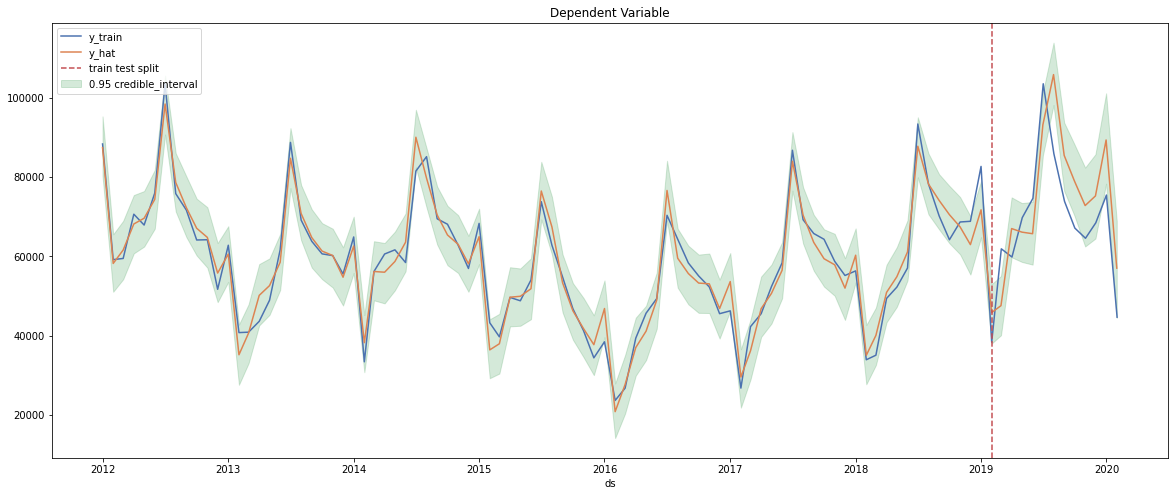

In [74]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

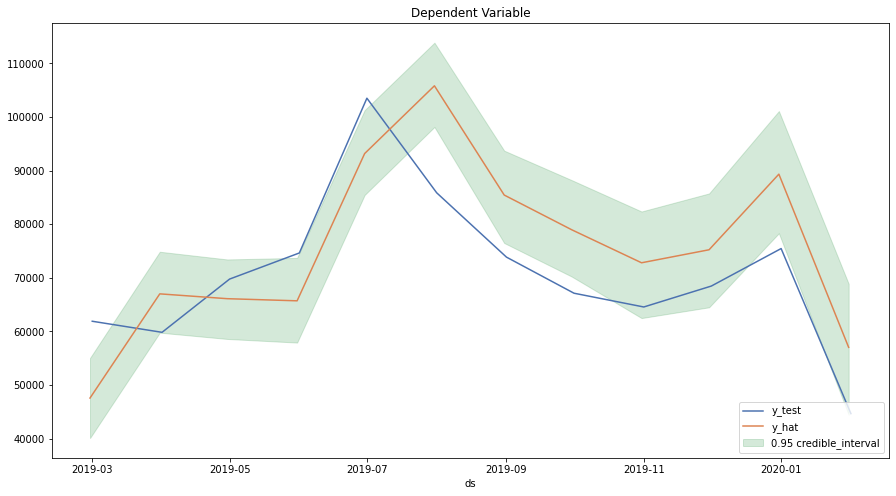

In [75]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

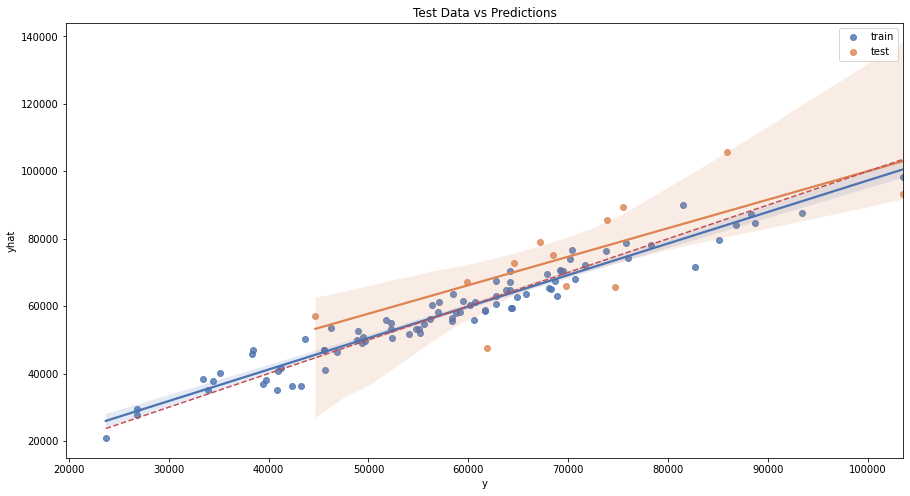

In [76]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [77]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9421236619810577
r2 test: 0.3045257991272081
------------------------------
mae train: 2971.087504103042
mae test: 10746.523055927913
mape train: 5.514454946369847
mape test: 15.622748414467063
RMSE train: 3747.9773124992134
RMSE test: 11496.84860224308


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



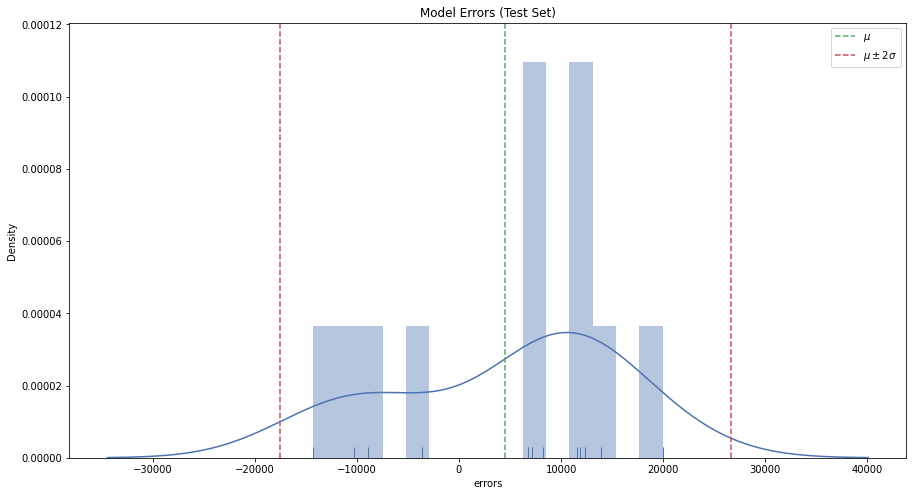

In [78]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

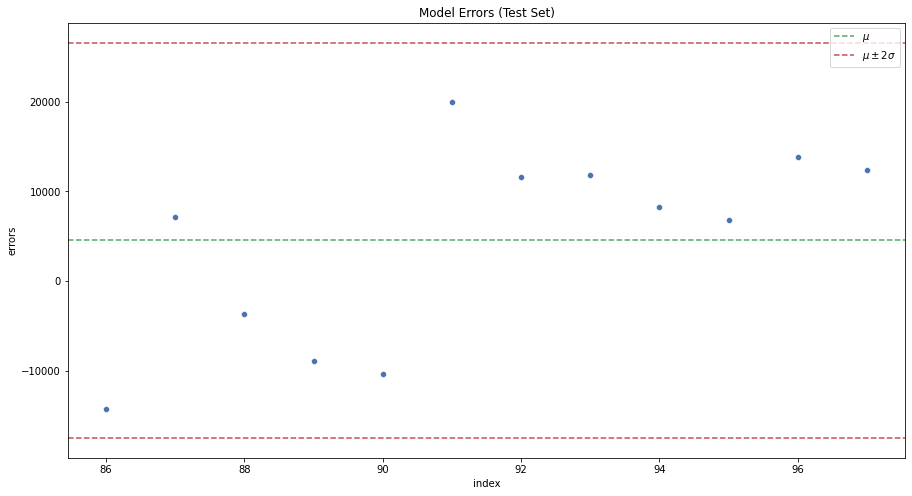

In [79]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



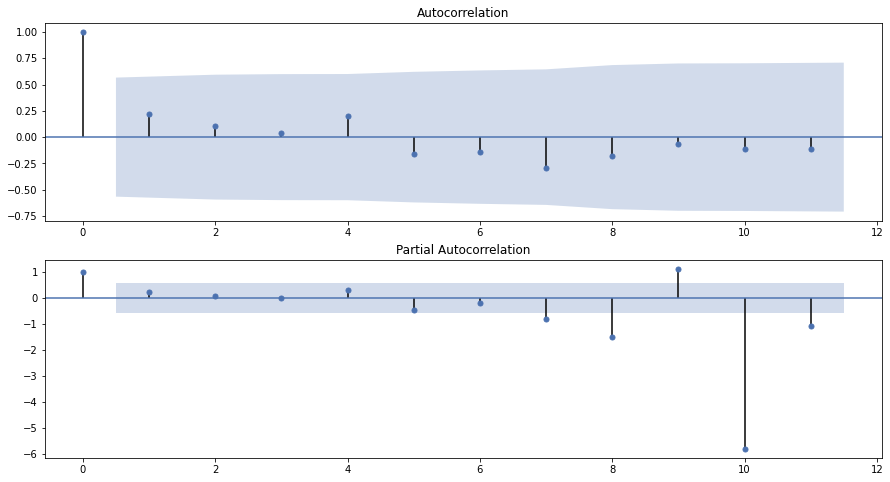

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

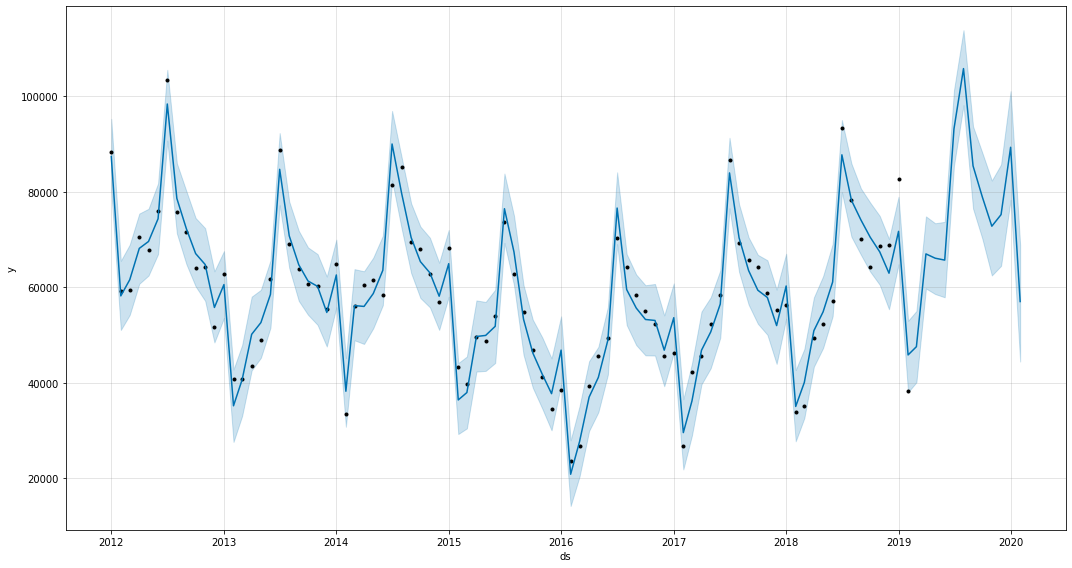

In [81]:
# Plotting the generated forecast
fig1 = model_3.plot(forecast, uncertainty=True, figsize=(15,8))

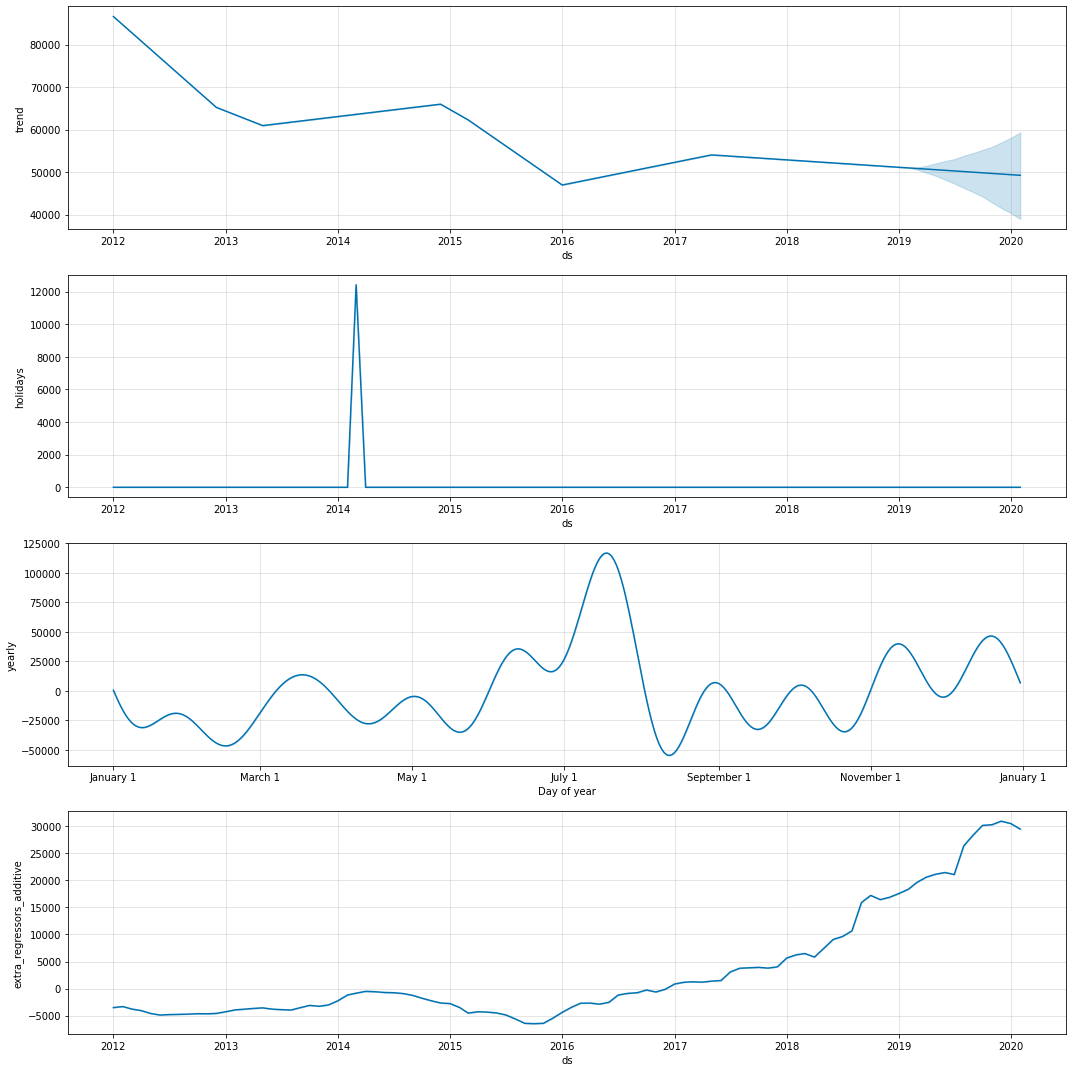

In [82]:
# Plotting the forecast components.
fig2 = model_3.plot_components(forecast, figsize=(15,15))

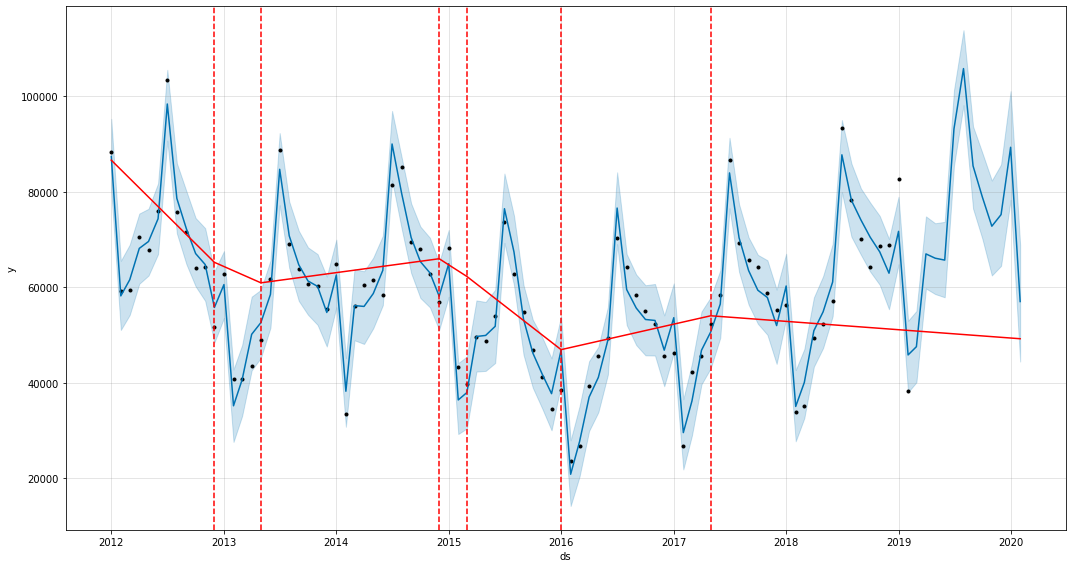

In [83]:
from fbprophet.plot import add_changepoints_to_plot

fig = model_3.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model_3, forecast)

In [84]:
# Listing all the change points in the model
deltas = model_3.params['delta'].mean(0)
cp = pd.DataFrame(model_3.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


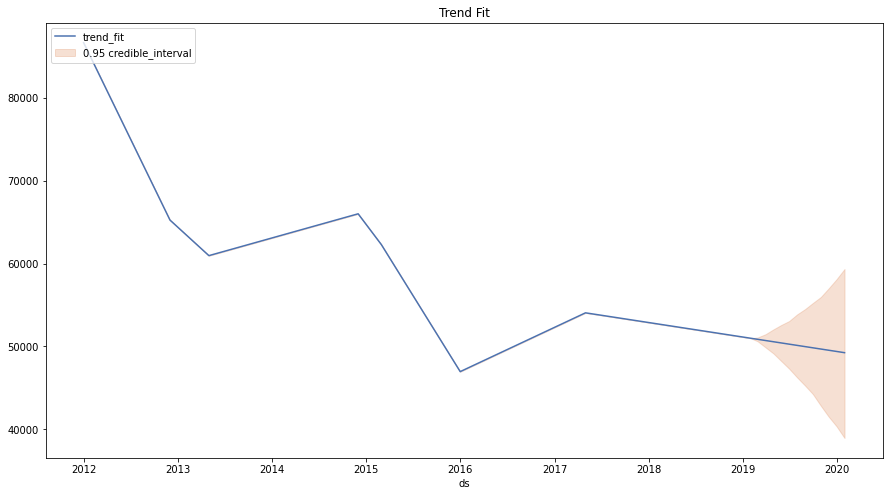

In [85]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [86]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model_3, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


ds          yhat    yhat_lower    yhat_upper            y              cutoff
0 2017-02-01  29774.594204  23736.290733  36011.067015  26817.99999 2017-01-01 19:12:00
1 2017-03-01  31858.905850  26190.278387  38563.509948  42302.00002 2017-01-01 19:12:00
2 2017-04-01  43138.662974  37016.944173  49423.078204  45565.00001 2017-01-01 19:12:00
3 2017-05-01  46095.280120  39912.597916  52859.645023  52396.00001 2017-01-01 19:12:00
4 2017-06-01  52467.980058  45610.422828  59616.980180  58382.99999 2017-01-01 19:12:00

ds          yhat    yhat_lower    yhat_upper            y     cutoff
163 2018-10-01  68654.714338  60121.686775  78383.863383  64194.00001 2018-02-01
164 2018-11-01  63819.179448  54314.117575  74245.361183  68665.99998 2018-02-01
165 2018-12-01  57361.149150  46469.305332  68798.816175  68836.99998 2018-02-01
166 2019-01-01  64851.527260  52820.636403  78196.749887  82661.99985 2018-02-01
167 2019-02-01  41971.569369  28827.060605  55704.197055  38387.00008 2018-02-01

In [87]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

horizon           mse         rmse          mae      mape     mdape  coverage
0 58 days 09:36:00  2.650756e+07  5148.548996  4003.734781  0.092665  0.046174   0.75000
1 58 days 14:24:00  2.451218e+07  4950.977236  3818.425240  0.085533  0.044124   0.78125
2 58 days 19:12:00  2.326452e+07  4823.330701  3745.698606  0.082448  0.044124   0.81250
3 59 days 00:00:00  2.407804e+07  4906.937612  3908.620284  0.086424  0.062471   0.81250
4 59 days 04:48:00  2.539694e+07  5039.537341  4144.090854  0.089671  0.073230   0.81250

In [88]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         6.60623e+07
rmse                            7880.85
mae                             6735.18
mape                           0.130222
mdape                          0.114704
coverage                       0.619109
dtype: object

In [89]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

horizon           mae
0    27 days 19:12:00  11832.174595
1    28 days 00:00:00   5385.062729
2    28 days 04:48:00   2058.806868
3    28 days 09:36:00    969.225098
4    28 days 14:24:00    916.797499
5    28 days 19:12:00   5552.514806
6    29 days 00:00:00   1448.097774
7    29 days 04:48:00   1031.230207
8    29 days 09:36:00    604.592162
9    29 days 14:24:00   2710.824672
10   29 days 19:12:00   7519.295658
11   30 days 04:48:00   2956.594214
12   30 days 09:36:00   5087.262938
13   58 days 04:48:00  10443.094170
14   58 days 09:36:00   5995.647483
15   58 days 14:24:00   2420.110075
16   58 days 19:12:00   4221.436595
17   59 days 00:00:00   2817.389404
18   59 days 04:48:00   4684.326614
19   59 days 09:36:00   1575.652050
20   59 days 14:24:00    373.884376
21   59 days 19:12:00   2786.206126
22   60 days 00:00:00   2502.351490
23   60 days 04:48:00   7603.321989
24   60 days 19:12:00   7335.597919
25   88 days 19:12:00  10292.107386
26   89 days 00:00:00   4232.420345
27   89 days 04:48:00   2426.337036
28   89 days 09:36:00   3473.383398
29   89 days 14:24:00   4290.679061
30   89 days 19:12:00    458.425394
31   90 days 00:00:00    749.850756
32   90 days 04:48:00   1974.479090
33   90 days 09:36:00   2569.057125
34   90 days 14:24:00   8345.348356
35   91 days 04:48:00   7421.126649
36  119 days 04:48:00   9362.814446
37  119 days 09:36:00   4872.040957
38  119 days 19:12:00   7973.147752
39  120 days 00:00:00   4103.789143
40  120 days 04:48:00    232.287818
41  120 days 09:36:00    458.052414
42  120 days 14:24:00   1548.705717
43  120 days 19:12:00   4526.956756
44  121 days 00:00:00   7825.713936
45  121 days 14:24:00   8119.046046
46  149 days 14:24:00  13195.503464
47  149 days 19:12:00   9977.931749
48  150 days 00:00:00   6776.014350
49  150 days 04:48:00   6921.209116
50  150 days 09:36:00   5825.655164
51  150 days 14:24:00    686.240299
52  150 days 19:12:00   1266.139998
53  151 days 00:00:00    239.118887
54  151 days 04:48:00   3892.021151
55  151 days 09:36:00   7677.131264
56  152 days 00:00:00   7495.301018
57  180 days 00:00:00  12620.410152
58  180 days 04:48:00   9031.297100
59  180 days 09:36:00   4042.438809
60  180 days 14:24:00   8516.010828
61  180 days 19:12:00   8073.102522
62  181 days 00:00:00   1339.278702
63  181 days 04:48:00    638.603667
64  181 days 09:36:00    805.378345
65  181 days 14:24:00   3444.985576
66  181 days 19:12:00  10216.936251
67  182 days 09:36:00   7605.258315
68  210 days 09:36:00  12610.339421
69  210 days 14:24:00  10602.598014
70  210 days 19:12:00     95.800039
71  211 days 00:00:00   7870.471632
72  211 days 04:48:00   7238.027930
73  211 days 09:36:00   2185.400213
74  211 days 14:24:00    182.991414
75  211 days 19:12:00   7674.333621
76  212 days 00:00:00   1879.491800
77  212 days 04:48:00   9035.094349
78  212 days 19:12:00   9823.840730
79  240 days 19:12:00  15338.281400
80  241 days 00:00:00  10043.061391
81  241 days 04:48:00    670.353899
82  241 days 09:36:00   8206.150544
83  241 days 14:24:00  13247.208855
84  241 days 19:12:00   9127.332230
85  242 days 00:00:00   3138.821536
86  242 days 04:48:00   5234.906966
87  242 days 09:36:00   4380.630364
88  242 days 14:24:00   8583.878039
89  243 days 04:48:00   8568.147755
90  271 days 04:48:00  13797.891712
91  271 days 09:36:00   9886.157077
92  271 days 14:24:00   1501.411440
93  271 days 19:12:00   9524.868974
94  272 days 00:00:00  12774.575557
95  272 days 04:48:00   8129.504195
96  272 days 09:36:00   4778.963972
97  272 days 19:12:00  10150.746784
98  273 days 00:00:00   5694.514030
99  273 days 14:24:00   8124.904082
100 301 days 14:24:00  13313.880979
101 301 days 19:12:00  12443.942235
102 302 days 00:00:00   1017.514106
103 302 days 04:48:00   8588.314857
104 302 days 09:36:00  12091.786802
105 302 days 14:24:00   9339.465574
106 302 days 19:12:00  13971.303417
107 303 days 00:00:00  11475.850830
108 303 days 04:48:00   9511.688540
109 303 days 09:36:00   3892.658742
110 304 days 00:00

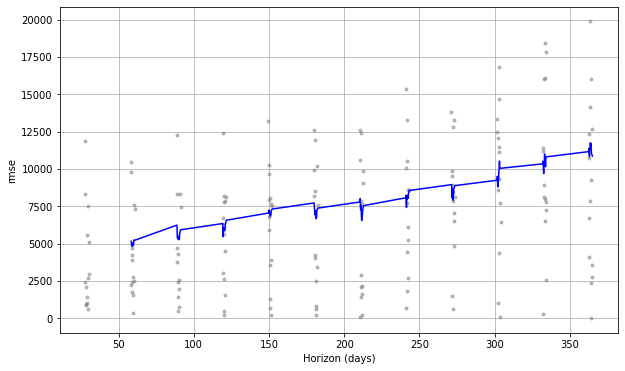

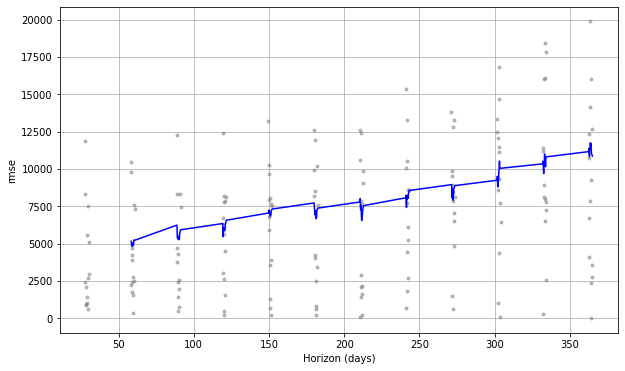

In [90]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [91]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [92]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

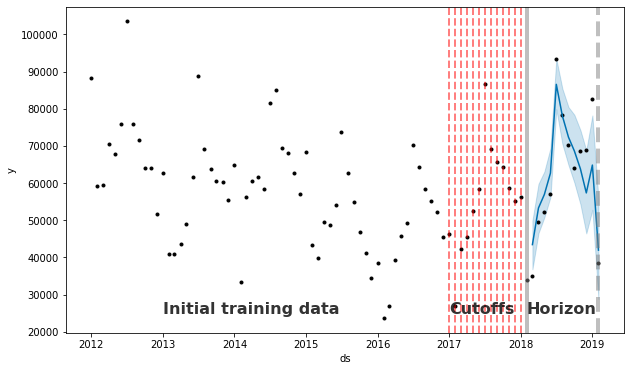

In [93]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model_3.history['ds'].values, model_3.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Ajuste de hiperparámetros


In [122]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df


In [123]:
def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(**param_dict, holidays=holidays)

    
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [124]:
#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.5],
                'changepoint_range':  [0.6, 0.7, 0.9],
                # 'holidays_prior_scale':[1.0, 5.0,  15.0],
                'seasonality_prior_scale':[0.5, 1.0, 5],
                'yearly_seasonality':[5, 10,  20],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

In [125]:
import itertools

#Prophet(,)
params_df = create_param_combinations(**param_grid)
params_df

changepoint_prior_scale  changepoint_range  seasonality_prior_scale  yearly_seasonality
0                       0.5                0.6                      0.5                   5
1                       0.5                0.6                      0.5                  10
2                       0.5                0.6                      0.5                  20
3                       0.5                0.6                      1.0                   5
4                       0.5                0.6                      1.0                  10
5                       0.5                0.6                      1.0                  20
6                       0.5                0.6                      5.0                   5
7                       0.5                0.6                      5.0                  10
8                       0.5                0.6                      5.0                  20
9                       0.5                0.7                      0.5                   5
10                      0.5                0.7                      0.5                  10
11                      0.5                0.7                      0.5                  20
12                      0.5                0.7                      1.0                   5
13                      0.5                0.7                      1.0                  10
14                      0.5                0.7                      1.0                  20
15                      0.5                0.7                      5.0                   5
16                      0.5                0.7                      5.0                  10
17                      0.5                0.7                      5.0                  20
18                      0.5                0.9                      0.5                   5
19                      0.5                0.9                      0.5                  10
20                      0.5                0.9                      0.5                  20
21                      0.5                0.9                      1.0                   5
22                      0.5                0.9                      1.0                  10
23                      0.5                0.9                      1.0                  20
24                      0.5                0.9                      5.0                   5
25                      0.5                0.9                      5.0                  10
26                      0.5                0.9                      5.0                  20

In [96]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='1825 days', period = '30.4 days', horizon = '365 days')

In [98]:
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(df_train,  metrics, param_dict, parallel="processes")
    results.append(cv_df)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


In [99]:
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()


 The best param combination is {'changepoint_prior_scale': 0.5, 'changepoint_range': 0.9, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 2.5, 'yearly_seasonality': 10.0}


horizon    365 days 00:00:00
rmse                 8743.97
mae                  7100.15
mape                0.131436
mdape               0.105652
dtype: object

In [115]:


m = Prophet(changepoint_prior_scale=0.5,
            changepoint_range=0.7,
            seasonality_prior_scale=1.0,
            yearly_seasonality=5,
            seasonality_mode='additive')


    
m.fit(df_train)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


horizon     215 days 04:55:04.918032788
mse                         5.35197e+07
rmse                            7295.82
mae                             6146.21
mape                           0.114801
mdape                         0.0909887
coverage                        0.63832
dtype: object

In [127]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))


# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)

fig.show()

In [150]:
# Make a zero days forecast just for plotting
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')
future = future.merge(df[reg_cols ], left_index=True, right_index=True)

forecast = m.predict(future)

# Transform back to reality from Box Cox
# forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
# bikerides['y'] = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()

upper_bound = go.Scatter(
    name='Upper Bound',
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='#FFECDC',
    fill='tonexty',
    showlegend=False)

trace = go.Scatter(
    name='Prediction',
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    line=dict(color='#FF7F0E'),
    fillcolor='#FFECDC',
    fill='tonexty')

lower_bound = go.Scatter(
    name='Lower Bound',
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines',
    showlegend=False)

data = [lower_bound, trace, upper_bound]

fig = go.Figure(data=data)


fig.add_trace(go.Scatter(
    x=df['ds'],
    y=df['y'],
    line_color='#1f77b4',
    name='Actual',
    marker=dict(color="#1f77b4"),

))

fig.add_trace(go.Scatter(
    x=['2019-02-15','2019-02-15'],
    y=[df.y.min(), df.y.max()],
    name = 'General Target',
    line=dict(color='grey', width=3, dash='dot'),
    mode = 'lines',
    showlegend=False),
)


# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)


fig.show()

In [119]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

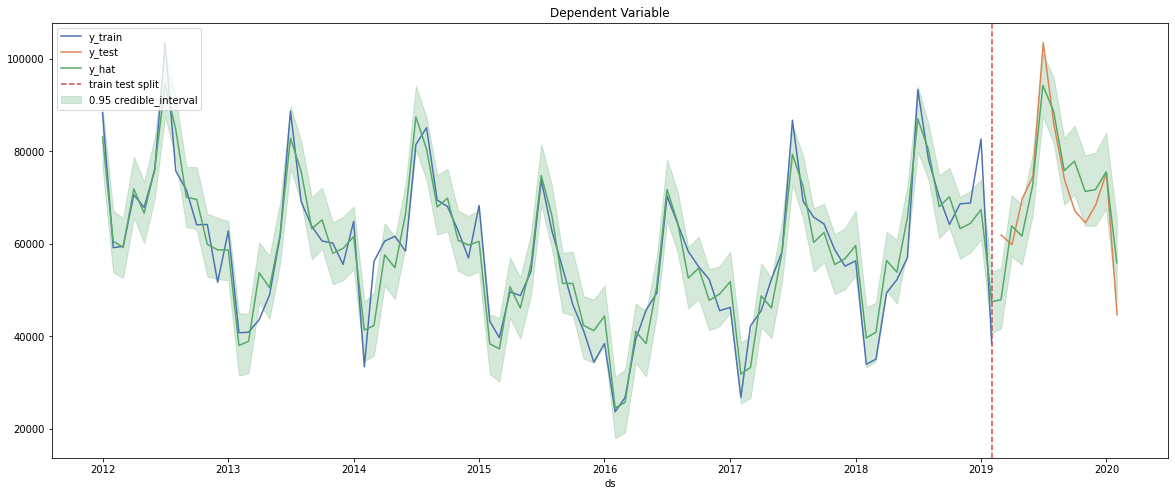

In [120]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [121]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.8895503998431541
r2 test: 0.703034433250624
------------------------------
mae train: 4194.208928076094
mae test: 6204.88408681663
mape train: 7.740326061554242
mape test: 9.609020076273035
RMSE train: 5177.600113516359
RMSE test: 7512.61871957426
